# Execution notebook
This notebook serves as a walk-through of the code to execute training of the ViT keypoint tracker

In [57]:
import os


In [58]:
#Prepare root directory

#Mac
#root = "/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch"

#Windows
root = r"C:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-pytorch"


# Download pretrained models (if not already downloaded)

In [59]:
import ipywidgets as widgets
from IPython.display import display
from utils.pretrained_model_downloader import download_model

# Available model names based on the options in the pretrained_model_downloader script
available_models = [
    "R50+ViT-B_16", 
    "ViT-B_16-224", 
    "ViT-B_16", 
    "ViT-B_32", 
    "ViT-B_8", 
    "ViT-L_16-224", 
    "ViT-L_16", 
    "ViT-L_32"
]

# Create a dropdown menu widget
model_dropdown = widgets.Dropdown(
    options=available_models,
    value="ViT-B_16",  # Default selected model
    description='Choose Model:',
)

# Display the dropdown
display(model_dropdown)

# Define a variable to hold the selected model name
model_name = model_dropdown.value

# Function to update the model_name when a new option is selected
def on_model_change(change):
    global model_name
    model_name = change['new']
    print(f"Selected model: {model_name}")

# Attach the on_model_change function to the dropdown
model_dropdown.observe(on_model_change, names='value')


Dropdown(description='Choose Model:', index=2, options=('R50+ViT-B_16', 'ViT-B_16-224', 'ViT-B_16', 'ViT-B_32'…

In [60]:
model_path = download_model(model_name, root)

print(model_path)

Model ViT-B_16 already exists in C:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-pytorch\model_files.
C:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-pytorch\model_files\ViT-B_16.npz


# Create project folder

In [62]:
import os
import ipywidgets as widgets
from IPython.display import display

# Define the root directory for projects
root = os.getcwd()  # Set to current working directory or customize it
projects_dir = os.path.join(root, "projects")

# Create the 'projects' folder if it doesn't exist
if not os.path.exists(projects_dir):
    os.makedirs(projects_dir)

# Function to create a project folder inside 'projects'
def create_project_folder(project_name):
    # Ensure a valid project name is provided
    if project_name.strip() == "":
        print("Please enter a valid project name.")
        return
    
    # Create the project folder path
    project_folder = os.path.join(projects_dir, project_name)
    
    # Check if the folder already exists
    if not os.path.exists(project_folder):
        os.makedirs(project_folder)
        print(f"Project folder '{project_folder}' created successfully.")
    else:
        print(f"Project folder '{project_folder}' already exists.")
    
    # Return the path to the project folder
    return project_folder

# Create widgets for project name input and button
project_name_input = widgets.Text(
    description="Project Name:",
    placeholder="Enter your project name",
)

# Display the input box and button
display(project_name_input)


Text(value='', description='Project Name:', placeholder='Enter your project name')

In [63]:
project_dict = create_project_folder(project_name_input.value)

Project folder 'c:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-pytorch\projects\Facemap' created successfully.


## Data Preprocessing

### Test-train split (incl. dropping NAs)

In [64]:
# Example usage:
base_dir = os.path.join(root, "data", "facemap_multi_video")
output_dir = os.path.join(project_dict, "data")

from utils.train_test_split import split_and_organize_data

# Call the function to process and combine data from multiple folders
split_and_organize_data(base_dir, output_dir)

('c:\\Users\\avs20\\Documents\\GitHub\\ViT_facemap\\ViT-pytorch\\projects\\Facemap\\data\\train\\train_data.csv',
 'c:\\Users\\avs20\\Documents\\GitHub\\ViT_facemap\\ViT-pytorch\\projects\\Facemap\\data\\test\\test_data.csv')

## Data augmentation

Arguments:

rotation = how much rotation (degrees) should be applied to the image
img_height = input image height (consider changing this to automatically be derived from meta data files if expecting it not to be uniform)
img_size = size in pixels (ViT expect 224)

## Define transformations to be applied, and input parameters to the arguments

In [65]:
#from utils.Dataaugmentation import Rotate, ZeroPadHeight, Rescale, HorizontalFlip, GaussianBlur
from torchvision import transforms, utils
import importlib
from utils.Dataaugmentation import Rotate, ZeroPadHeight, Rescale, HorizontalFlip, GaussianBlur

#from utils import Dataaugmentation
#importlib.reload(Dataaugmentation)

# Set the parameters for image augmentation
rotation = 10  # Degrees to rotate image
img_width = 846  # Width of the input image to pad the height to match
final_im_size = 224  # Final image size (224x224 pixels)

# Define transformations using transforms.Compose
rotate_rescale = transforms.Compose([
    Rotate(rotation),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

flip_rescale = transforms.Compose([
    HorizontalFlip(),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

pad_rescale = transforms.Compose([
    ZeroPadHeight(img_width),  # Use img_width instead of hardcoded value
    Rescale(final_im_size),
])

rotate_flip_rescale = transforms.Compose([
    HorizontalFlip(),
    Rotate(rotation),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

blur = transforms.Compose([
    GaussianBlur(),
    ZeroPadHeight(img_width),
    Rescale(final_im_size)
])

In [66]:
# Define a dictionary to associate names with each transformation
transforms_dict = {
    'rotate_rescale': rotate_rescale,
    'flip_rescale': flip_rescale,
    'pad_rescale': pad_rescale,
    'rotate_flip_rescale': rotate_flip_rescale,
    'blur': blur
}


# Import the AugmentedFaceDataset class
from utils.Dataaugmentation import AugmentedFaceDataset

In [67]:
#create augmented train set

# Define the paths
source_folder = os.path.join(project_dict, "data")

# Define paths using os.path.join for consistency
train_csv_file = os.path.join(source_folder, "train", "train_data.csv")
train_folder = os.path.join(source_folder, "train")
train_output_dir = os.path.join(source_folder, "train", "augmented_data")


# Initialize the dataset with defined transformations
face_dataset = AugmentedFaceDataset(csv_file=train_csv_file, root_dir=train_folder, output_dir=train_output_dir)

# Apply the transformations and save
face_dataset.apply_transforms_and_save(transforms_dict)

Before transformation: [[590.509301779291 64.6671841900048]
 [501.345212985891 104.791024147034]
 [565.246143287827 171.664090742084]
 [638.063482469104 153.831272983404]
 [177.38235703654 133.026318931611]
 [125.369971907057 177.60836332831]
 [149.147062251964 240.02322548369]
 [364.626943502679 238.537157337134]
 [352.738398330225 193.955112940434]
 [354.224466476782 284.60526988039]
 [296.267808761073 393.088244579026]
 [336.391648718102 433.212084536056]]
Landmarks before saving: [[143.3555717468983 37.35107030351865]
 [122.02225187682942 51.913042933996856]
 [141.69319405696984 66.41236550483296]
 [159.79978341233956 58.41442817841036]
 [39.124691181111565 74.17056643125301]
 [27.650641488356612 88.18687629511844]
 [36.68991523528245 103.36851382576013]
 [92.62069146192133 93.07373326983986]
 [87.48817865280448 81.99544555962221]
 [92.02831467796408 105.56440897843734]
 [81.93765349930875 136.51637485430683]
 [94.20365776093344 145.13397708089278]]
DataFrame structure in _save_aug

In [68]:
#create augmented test set

# Define the paths
source_folder = os.path.join(project_dict, "data")

# Define paths using os.path.join for consistency
test_csv_file = os.path.join(source_folder, "test", "test_data.csv")
test_folder = os.path.join(source_folder, "test")
test_output_dir = os.path.join(source_folder, "test", "augmented_data")


# Initialize the dataset with defined transformations
face_dataset = AugmentedFaceDataset(csv_file=test_csv_file, root_dir=test_folder, output_dir=test_output_dir)

# Apply the transformations and save
face_dataset.apply_transforms_and_save(transforms_dict)

Before transformation: [[593.481438072404 66.1532523365614]
 [504.317349279005 109.249228586704]
 [566.732211434384 174.636227035197]
 [642.521686908774 155.317341129961]
 [169.952016303757 138.970591517837]
 [114.96749488116 192.469044793877]
 [156.577402984747 257.85604324237]
 [306.670285786969 232.592884750907]
 [336.391648718102 195.44118108699]
 [321.530967252536 287.577406173503]
 [314.100626519752 393.088244579026]
 [354.224466476782 421.323539363602]]
Landmarks before saving: [[144.19606732898296 37.60191465975871]
 [122.99894211128185 52.93888038910284]
 [142.21558783728796 67.11903250710235]
 [161.02647812237484 58.596946438054026]
 [37.46608484609413 76.06218311196706]
 [25.628220854540572 92.5401244656236]
 [39.43807878923994 107.67684193597358]
 [77.28653616711664 94.18846483937001]
 [83.30808557153274 83.13452917161612]
 [83.66812851542066 107.84257620242543]
 [86.57204303471451 135.6964616951493]
 [98.29326868686941 141.21409152627115]]
DataFrame structure in _save_augm

In [69]:
# set paths to train and test augmented data
# Train
train_output_dir = os.path.join(source_folder, "train", "augmented_data")
train_csv = os.path.join(train_output_dir, "augmented_labels.csv")

# Test
test_output_dir = os.path.join(source_folder, "test", "augmented_data")
test_csv = os.path.join(test_output_dir, "augmented_labels.csv")

print(train_output_dir)


c:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-pytorch\projects\Facemap\data\train\augmented_data


# Running Training

In order to train the ViT, the following sections are run. Subprocess is used in order to run train.py from within a python script.

For reference, the following arguments are to be specified for the training model.

"--name", default="test" 
--> "Name of this run. Used for monitoring."

"--dataset", default="facemap" 
--> "Which downstream task and dataset to use"

"--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16", "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"], default="ViT-B_16"
-->help="Which variant to use."

"--pretrained_dir", type=str, default="ViT-B_16.npz"
--> "Where to search for pretrained ViT models. If not modified, will search in the directory where .ipynb project execution file is placed."

"--output_dir", default="output", type=str
-->"The output directory where checkpoints will be written."

"--img_size", default=224, type=int
--> ="Resolution size for image"

"--train_batch_size", default=20, type=int
--> "Batch size for training."

"--eval_batch_size", default=20, type=int
h--> "Total batch size for eval."

"--eval_every", default=100, type=int,
--> "Run prediction on validation set every so many steps. Will always run one evaluation at the end of training."

"--learning_rate", default=2e-4, type=float,
--> "The initial learning rate for the optimizer."

"--weight_decay", default=1e-2, type=float,
--> "Weight deay if we apply some."

"--num_steps", default=3000, type=int,
--> "Total number of training epochs to perform."

"--decay_type", choices=["cosine", "linear"], default="linear", #changed from cosine as I believe this is what Yichen did
--> "How to decay the learning rate."

"--warmup_steps", default=500, type=int,
--> "Step of training to perform learning rate warmup for."

"--max_grad_norm", default=1.0, type=float,
--> "Max gradient norm."

"--local_rank", type=int, default=-1,
--> "local_rank for distributed training on gpus" - I think this might be if you have more than one GPU available, you can distribute training. Or if one GPU has more than one core

'--seed', type=int, default=42,
--> "random seed for initialization"

'--gradient_accumulation_steps', type=int, default=1, # tried adjusting this from 1 to 25 to match Yichen
--> "Number of updates steps to accumulate before performing a backward/update pass."

('--fp16', action='store_true',
--> "Whether to use 16-bit float precision instead of 32-bit")

'--fp16_opt_level', type=str, default='O2',
-->"For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")

'--loss_scale', type=float, default=0,
-->"Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True. 0 (default value): dynamic loss scaling. Positive power of 2: static loss scaling value.


In [ ]:
import subprocess

# Define the command to run the script with arguments
command = [
    "python", "train_epochs.py",
    "--name", "experiment_20240825",
    "--dataset", "facemap",
    "--model_type", "ViT-B_16",
    "--pretrained_dir", model_path,
    "--output_dir", project_dict,
    "--train_batch_size", str(20),
    "--eval_batch_size", str(20),
    "--eval_every", str(2),
    "--num_epochs", str(2),
    "--train_csv_file", train_csv,
    "--train_data_dir", train_output_dir,
    "--test_csv_file", test_csv,
    "--test_data_dir", test_output_dir,
    "--wandb_project_name", "facemap_project_wandb"
]

# Use Popen to stream output
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Print the output in real-time
for line in iter(process.stdout.readline, ''):
    # Strip any extra newline characters for cleaner output
    print(line.strip())

# Wait for the process to finish and capture any errors
process.wait()

# Print errors, if any
if process.returncode != 0:
    print(f"Errors:\n{process.stderr.read().strip()}")


# Video inference

In [ ]:
# Create 10 second video for testing purpose

import cv2

def create_one_second_video(input_video_path, output_video_path):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)
    
    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    # Get the video's frames per second (fps) and size information
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate the number of frames for 10 seconds
    frames_to_extract = int(fps)*10
    
    # Define the codec and create a VideoWriter object to save the output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Read and write frames to the output file
    frame_count = 0
    while cap.isOpened() and frame_count < frames_to_extract:
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
        frame_count += 1
    
    # Release resources
    cap.release()
    out.release()
    print(f"10-second video saved to {output_video_path}")

# Example usage
input_video_path = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/Facemap_videos/cam1_G7c1_1.avi'
video_path = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/Facemap_videos/cam1_G7c1_1_10seconds.avi'
create_one_second_video(input_video_path, video_path)

## Load model

In [ ]:
import wandb
from pathlib import Path

# Initialize the WandB API
api = wandb.Api()

# Replace with your project path and run ID
project_path = "anna-stuckert-university-of-st-andrews/facemap_project"

#find the run_id by going to your run of choice, and check the URL
# https://wandb.ai/anna-stuckert-university-of-st-andrews/facemap_project/runs/2hjtqnwr?nw=nwuserannastuckert
# here it would be 2hjtqnwr
run_id = "2hjtqnwr"

# Get the specific run
run = api.run(f"{project_path}/{run_id}")

# Define the file path - this is the path inside the wandb repo where the model is stored. in this case, the mode(s) is stored in the output/ folder in the files folder under the run in wandb.
file_path = "output/facemap_with_augmentation_300epochs_checkpoint_epoch_299.pth"

# Download the file
file = run.file(file_path)

# Specify the download directory (defaults to current working directory)
output_dir = Path("projects") / "Facemap" / "wandb_model"

# Download the file
downloaded_file_path = file.download(replace=True, root=output_dir)

# Print the actual download location
print(f"Downloaded {file.name} to {downloaded_file_path}")


In [ ]:
from pathlib import Path
from models.modeling import VisionTransformer, CONFIGS

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_KPs=24, zero_head=False, img_size=224, vis=True)
# Define the path in an OS-independent way
checkpoint_path = Path("projects") / "Facemap" / "wandb_model" / "output" / "facemap_with_augmentation_300epochs_checkpoint_epoch_299.pth"
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))  # Load the checkpoint #delete map_location=torch.device('cpu') if run on GPU
model.load_state_dict(checkpoint['state_dict'])
print(model)

## Run video inference

In [ ]:

import torch
import glob
import os
from utils.video_inference import overlay_keypoints_on_video_and_save_csv, run_inference_on_video
# Example usage
video_dir = '/Users/annastuckert/Documents/GitHub/ViT_facemap/ViT-pytorch/Facemap_videos/'  # Directory containing video files
output_dir = 'Facemap_videos/video_inference/'  # Directory to save output videos and CSVs

# Assume the model is already loaded and available as `model`
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    print(f"Creating directory: {output_dir}")
    os.makedirs(output_dir)

# Process each video file in the directory
video_files = glob.glob(os.path.join(video_dir, '*.avi'))  # Adjust extension if needed

for video_path in video_files:
    base_name = os.path.basename(video_path)
    name, _ = os.path.splitext(base_name)
    output_video_path = os.path.join(output_dir, f'{name}_keypoints.mp4')
    output_csv_path = os.path.join(output_dir, f'{name}_keypoints.csv')

    print(f"Processing video: {video_path}")

    # Run inference on the video
    keypoints_list = run_inference_on_video(video_path, model, device)

    # Overlay keypoints and save results
    overlay_keypoints_on_video_and_save_csv(video_path, keypoints_list, output_video_path, output_csv_path)

    print(f"Output video saved to: {output_video_path}")
    print(f"Output CSV saved to: {output_csv_path}")


# Check model inference predictions against test_set labels and predictions

In [ ]:
# Load model

In [53]:
from pathlib import Path
from models.modeling import VisionTransformer, CONFIGS
import torch
# Prepare Model
config = CONFIGS["ViT-B_16"]
#config = CONFIGS["R50-ViT-B_16"]
model = VisionTransformer(config, num_KPs=24, zero_head=False, img_size=224, vis=True)
# Define the path in an OS-independent way
#checkpoint_path = Path("projects") / "FaceFacemap_fullData_withAugmentation" / "output" / "facemap_ViT_ResNet_w_data_augmentation_checkpoint_epoch_299.pth" - with dropout, vit16-b resnet50
#checkpoint_path = Path("projects") / "Facemap" / "output" / "facemap_fullData_with_augmentation_300epochs_checkpoint_epoch_49.pth" # with dropout, vit16-b
#checkpoint_path = Path("output_50 models") /  "test_test_checkpoint_epoch_49.pth" #with dropout, vit16-b
#checkpoint_path = Path("projects") / "Facemap_without augmentations" / "output" / "facemap_no_augmentation_more_epochs_testing20240907.pth"
checkpoint_path = Path("projects") / "Facemap" / "output" / "facemap_ViT_imagenetNormalize_w_data_augmentation_checkpoint_epoch_149.pth"

checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))  # Load the checkpoint #delete map_location=torch.device('cpu') if run on GPU
model.load_state_dict(checkpoint['state_dict'])
print(model)



VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-11): 12 x Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=Tru

In [54]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import transforms

# Define the transform (assuming this is required elsewhere)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Uncomment if resizing is needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

from pathlib import Path



# Define the data path in an OS-independent way
data_path = Path("projects") / "Facemap_w_aug_ViT_resnet" / "data" / "test" / "augmented_data"

# Define the image name
imageName = 'cam1_G7c1_2_img0373_pad_rescale_augmented.jpg'

# Open the image (using the / operator to concatenate the path and file name)
im = Image.open(data_path / imageName)
x = transform(im)
x.size()

#labels = pd.read_csv(data_path /'augmented_labels.csv')
#labelsKepoints = labels.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:]

labels = pd.read_csv(data_path /'augmented_labels.csv')
labelsKepoints = labels.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:]

pred_path = Path("projects") / "Facemap_w_aug_ViT_resnet" / "output" 
#project_ouput_path = Path("projects") / "Facemap" / "output"
preds = pd.read_csv(pred_path /'predictions.csv')
predsKeypoints = preds.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:-1]



In [55]:
#Loading KP predictions form model forward pass
# Transform the image (assuming you have a transform function defined)
x = transform(im)

# Get model output
# Assuming the model is already defined and loaded
out = model(x.unsqueeze(0))

# Convert the model output to a format suitable for plotting
keypoints = out[0].detach().cpu().numpy()  # Detach and move to CPU if using a GPU

# Access the first row of keypoints since shape is (1, 24)
keypoints = keypoints[0]

print(keypoints)


Input tensor size: torch.Size([1, 197, 768])
[ 60.179955  39.785137  79.28831   49.7458    66.05056   63.069515
  49.46897   60.11117  144.59639   53.960396 163.02144   66.31099
 157.03372   76.62843  113.22302   74.30191  111.46953   65.0313
 114.10668   84.57116  127.80536  110.02355  118.52246  116.92074 ]


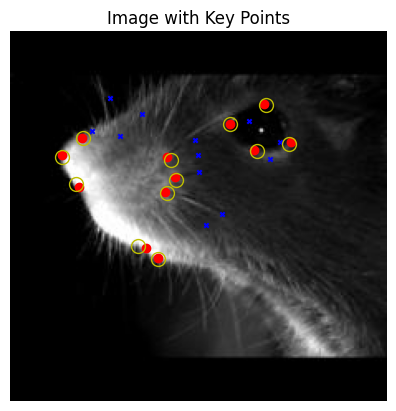

In [56]:
plt.imshow(im)
# Loop through the keypoints and plot them
for i in range(0, len(keypoints), 2):
    x_coord = keypoints[i]
    y_coord = keypoints[i + 1]
    plt.scatter(x_coord, y_coord, s=10, c='blue', marker='x')  # Plot each keypoint
for i in range(0, 23, 2):
    plt.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro')
    plt.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10) #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 

plt.title("Image with Key Points")
plt.axis('off')  # Turn off axis labels
plt.show()
 

In [ ]:
# Visualize attention maps overall for each layer

Input tensor size: torch.Size([1, 197, 768])
tensor([[[[9.5294e-01, 1.7890e-04, 1.4899e-04,  ..., 1.0862e-04,
           1.1749e-04, 1.3681e-04],
          [9.5753e-01, 2.3914e-04, 2.3781e-04,  ..., 1.6192e-04,
           1.7767e-04, 1.8398e-04],
          [9.5654e-01, 2.3794e-04, 2.6593e-04,  ..., 1.8436e-04,
           1.9777e-04, 1.8617e-04],
          ...,
          [9.5511e-01, 1.7251e-04, 1.9650e-04,  ..., 2.8617e-04,
           3.0358e-04, 2.8222e-04],
          [9.5401e-01, 1.8172e-04, 2.0295e-04,  ..., 2.8824e-04,
           3.2344e-04, 3.0836e-04],
          [9.5265e-01, 1.9143e-04, 1.9462e-04,  ..., 2.7381e-04,
           3.1503e-04, 3.2803e-04]],

         [[6.8402e-02, 6.5030e-05, 5.8638e-05,  ..., 4.7435e-05,
           4.9634e-05, 5.2325e-05],
          [7.1216e-02, 5.0688e-03, 5.3599e-03,  ..., 4.7124e-03,
           4.6573e-03, 4.2206e-03],
          [6.6155e-02, 5.7278e-03, 5.1965e-03,  ..., 4.6219e-03,
           4.5795e-03, 4.7964e-03],
          ...,
          [7.8

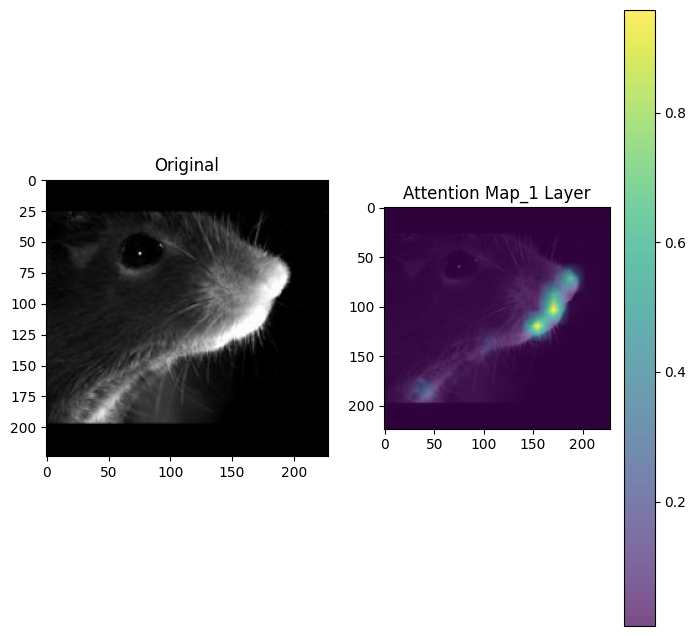

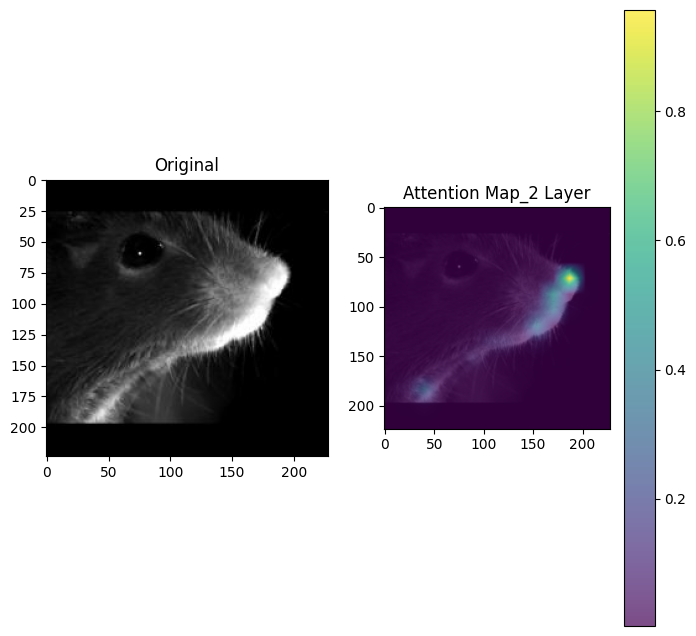

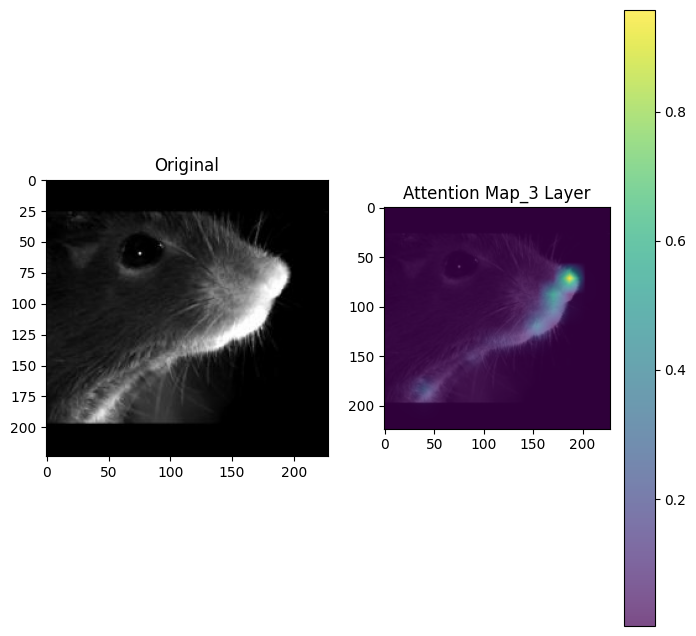

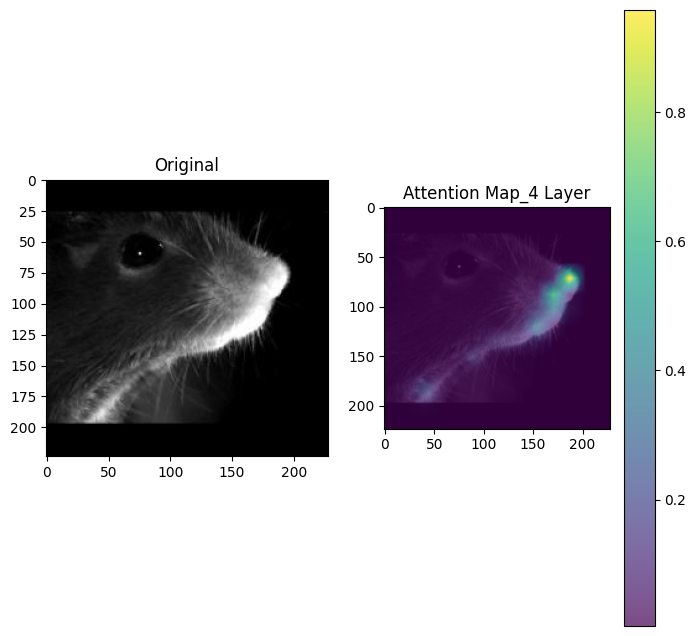

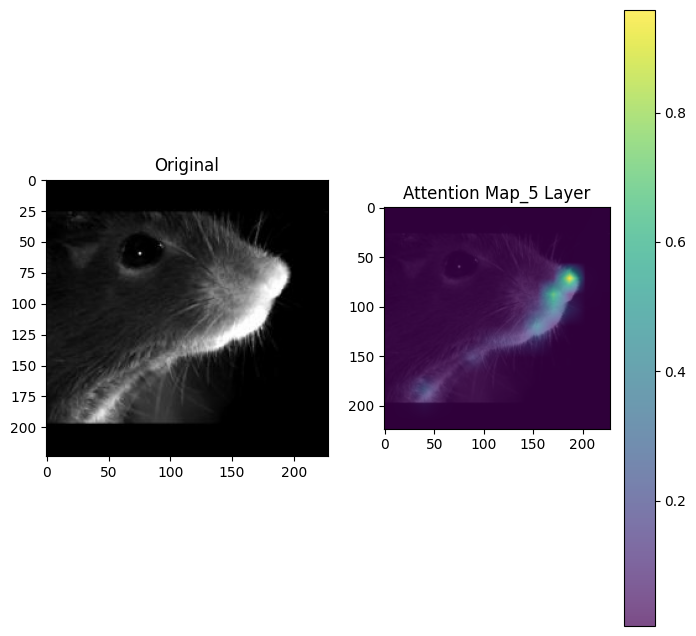

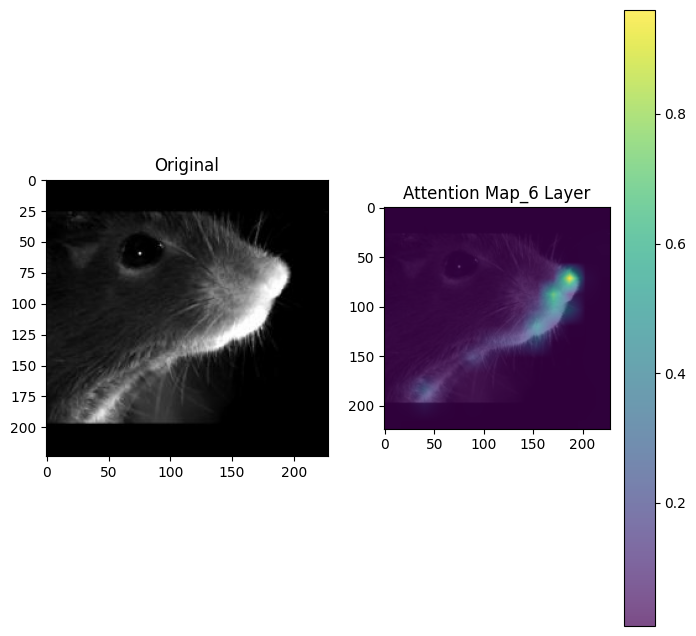

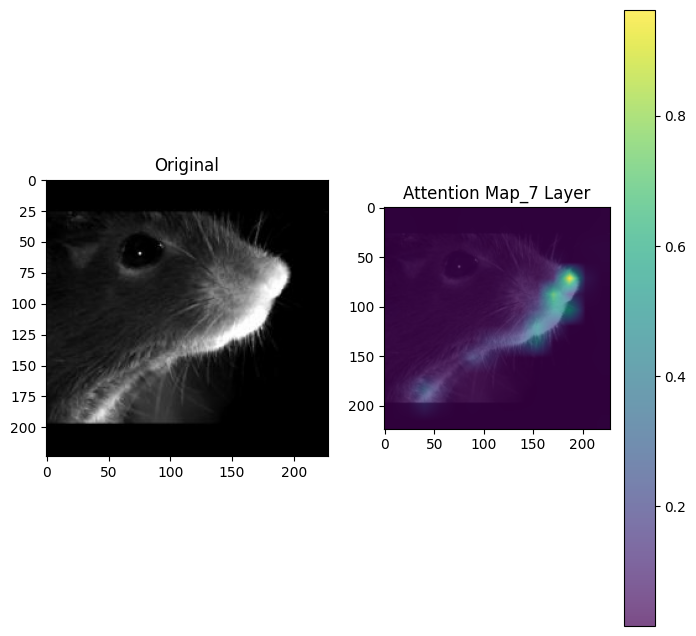

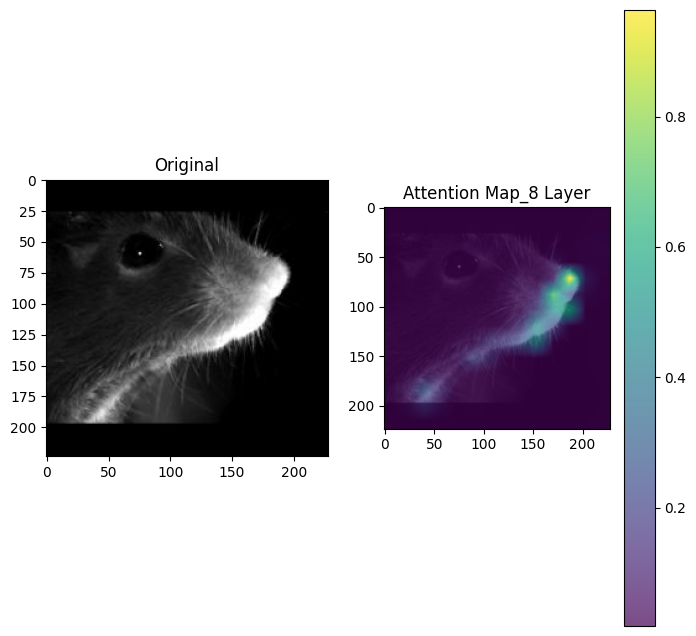

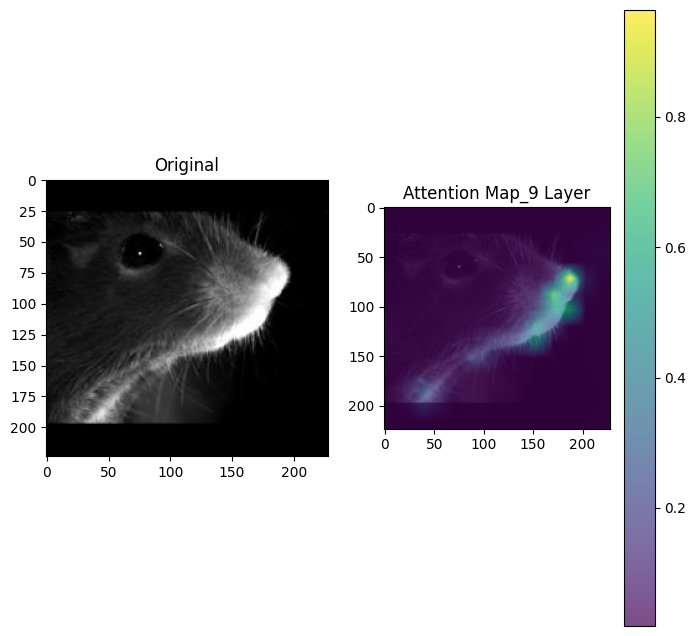

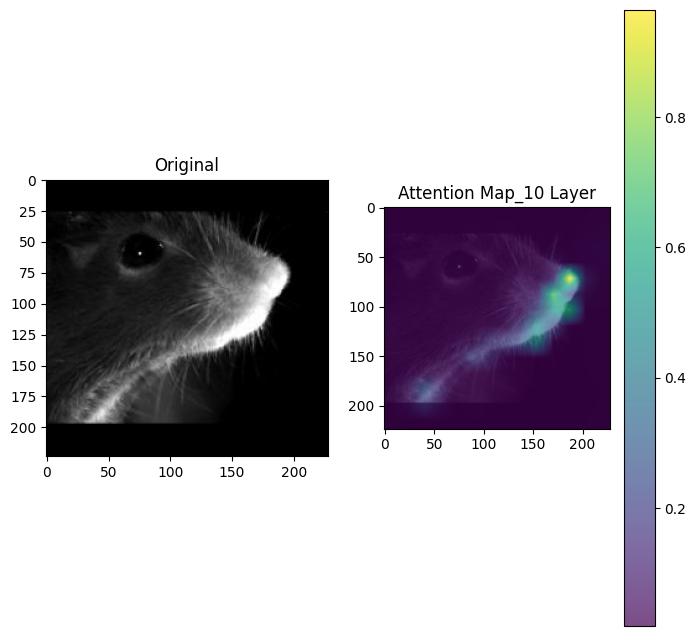

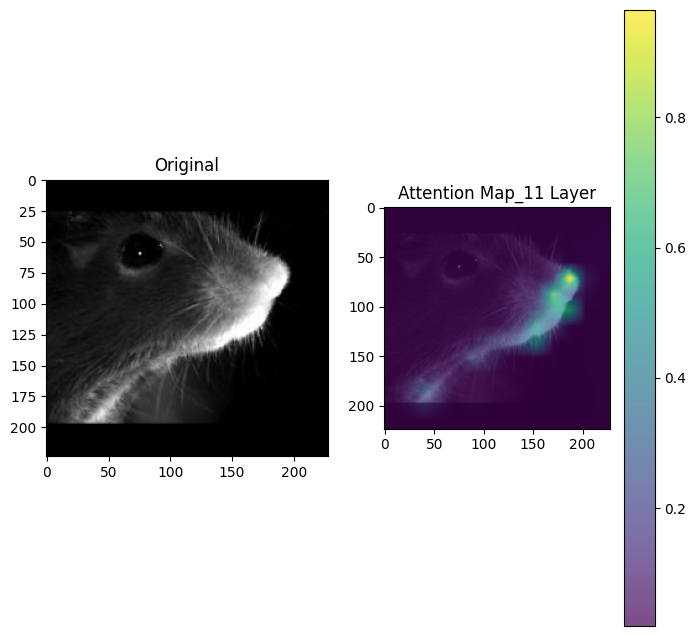

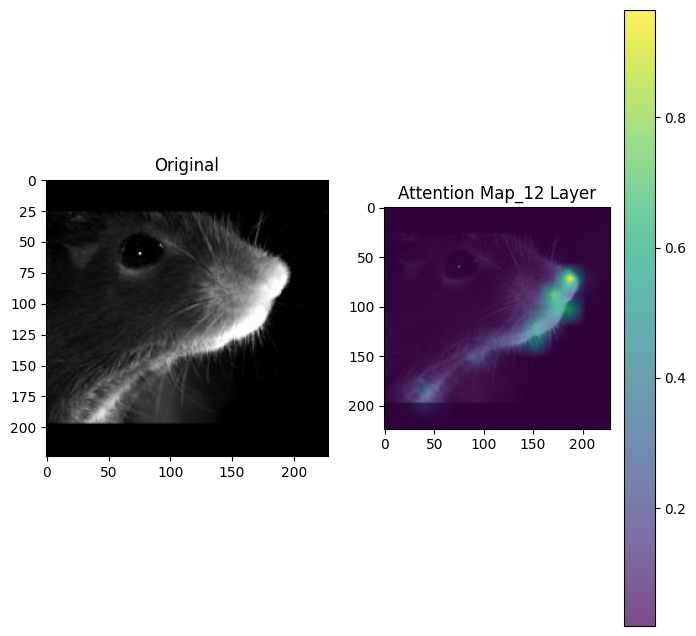

In [34]:
import cv2
# Assuming att_mat is obtained from your model
#logits, att_mat = model(x.unsqueeze(0)) # logits kunne vaere predictions, hvor kommer 197 fra?
logits, att_mat = model.forward(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
print(att_mat)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)

#result = (mask * im).astype("uint8")

for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 8))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(im)
    cax = ax2.imshow(mask, alpha=.7, cmap = 'viridis')
    fig.colorbar(cax, ax=ax2, orientation='vertical')

# heatmap for last layer

Input tensor size: torch.Size([1, 197, 768])


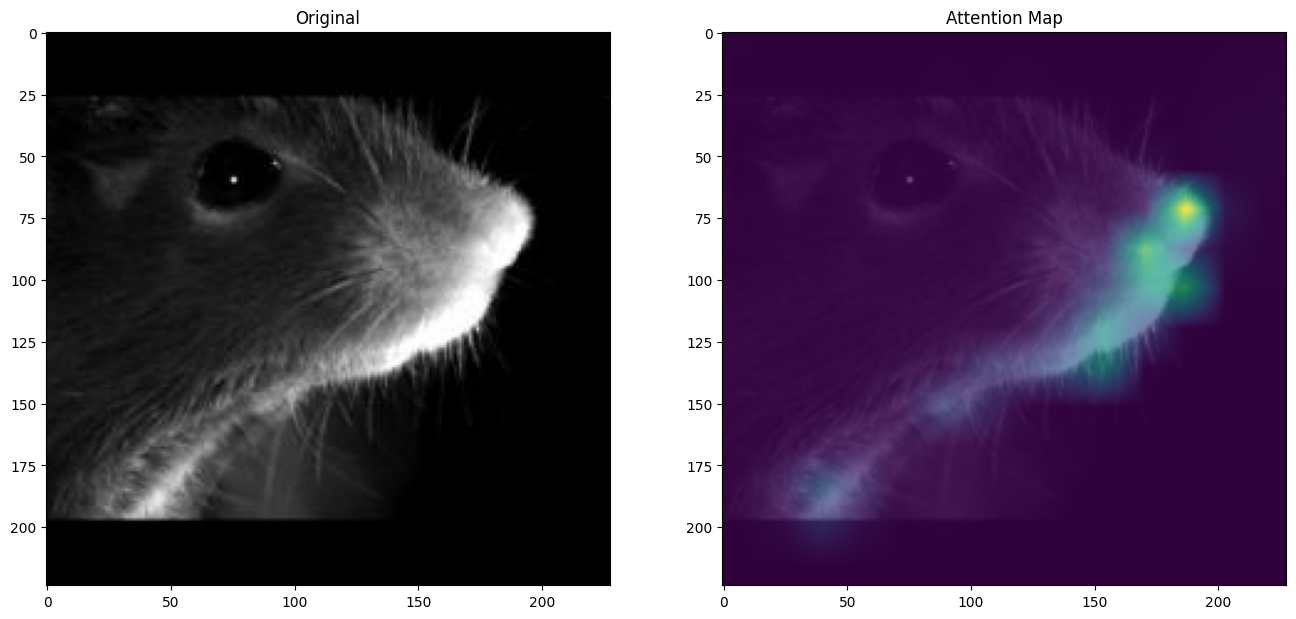

In [35]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1] # takes the last attention layer
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
#result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
#_ = ax2.imshow(result)
_ = ax2.imshow(im)
_ = ax2.imshow(mask, alpha=.7, cmap = 'viridis')

#cax = ax2.imshow(mask, cmap='viridis', interpolation='nearest', alpha=0.7)
#fig.colorbar(cax, ax=ax2, orientation='vertical')

In [ ]:
print(att_mat.shape)
print(logits.shape)
print(logits)

C:\Users\avs20\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


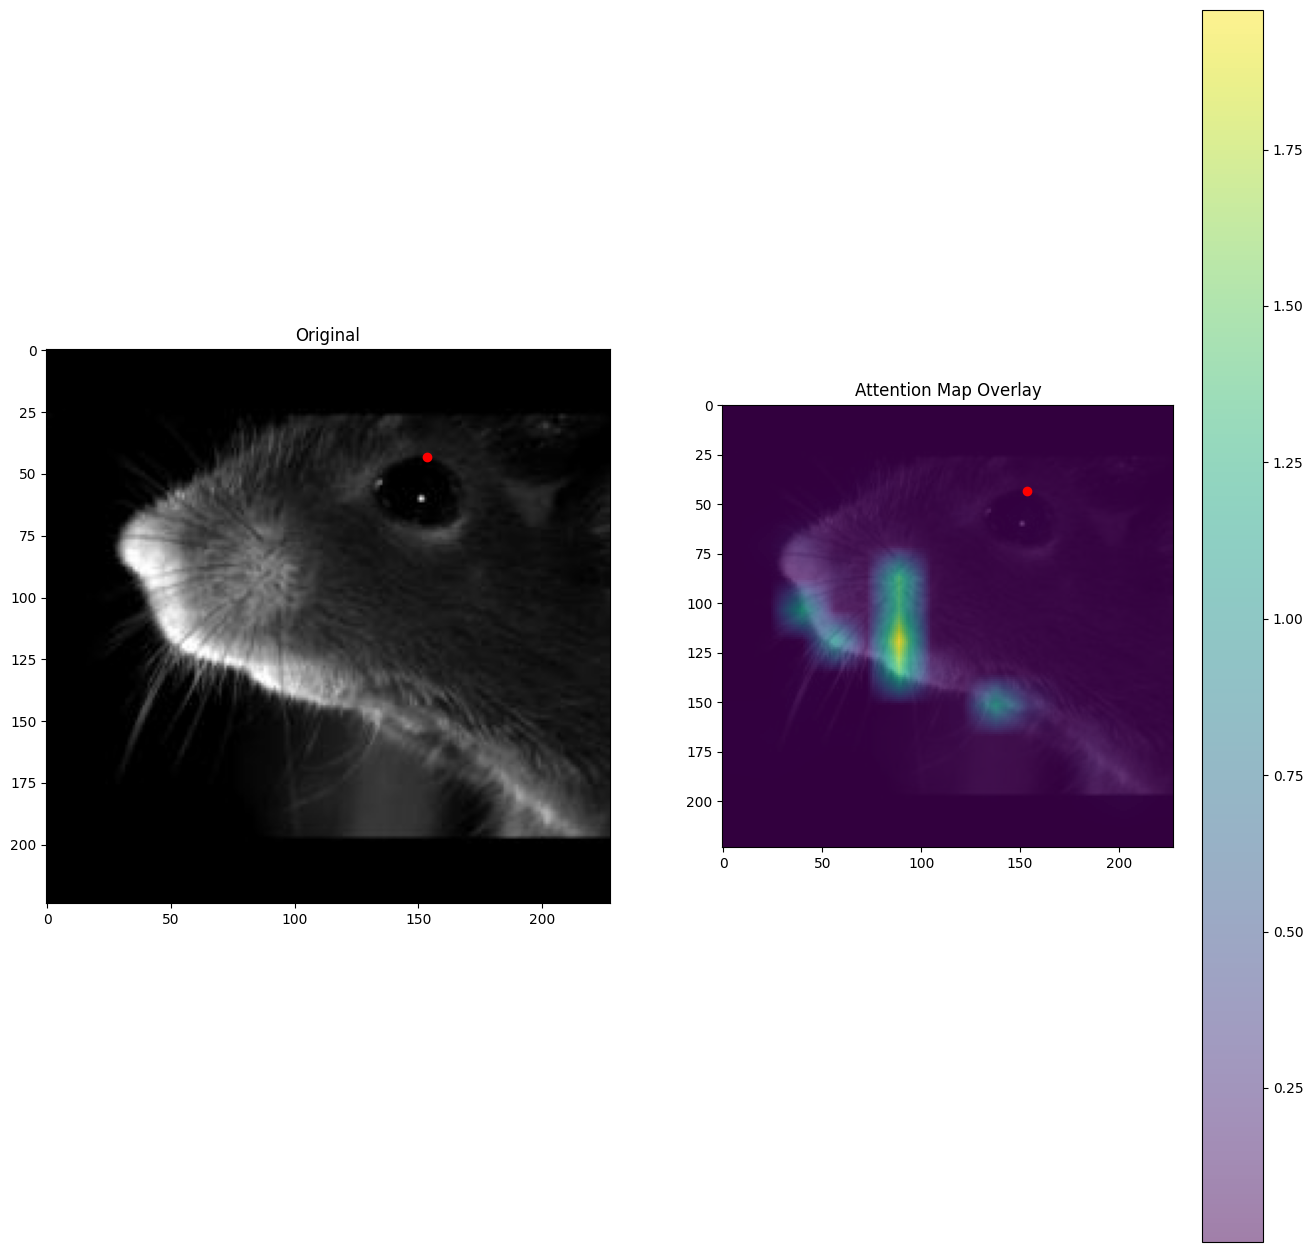

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


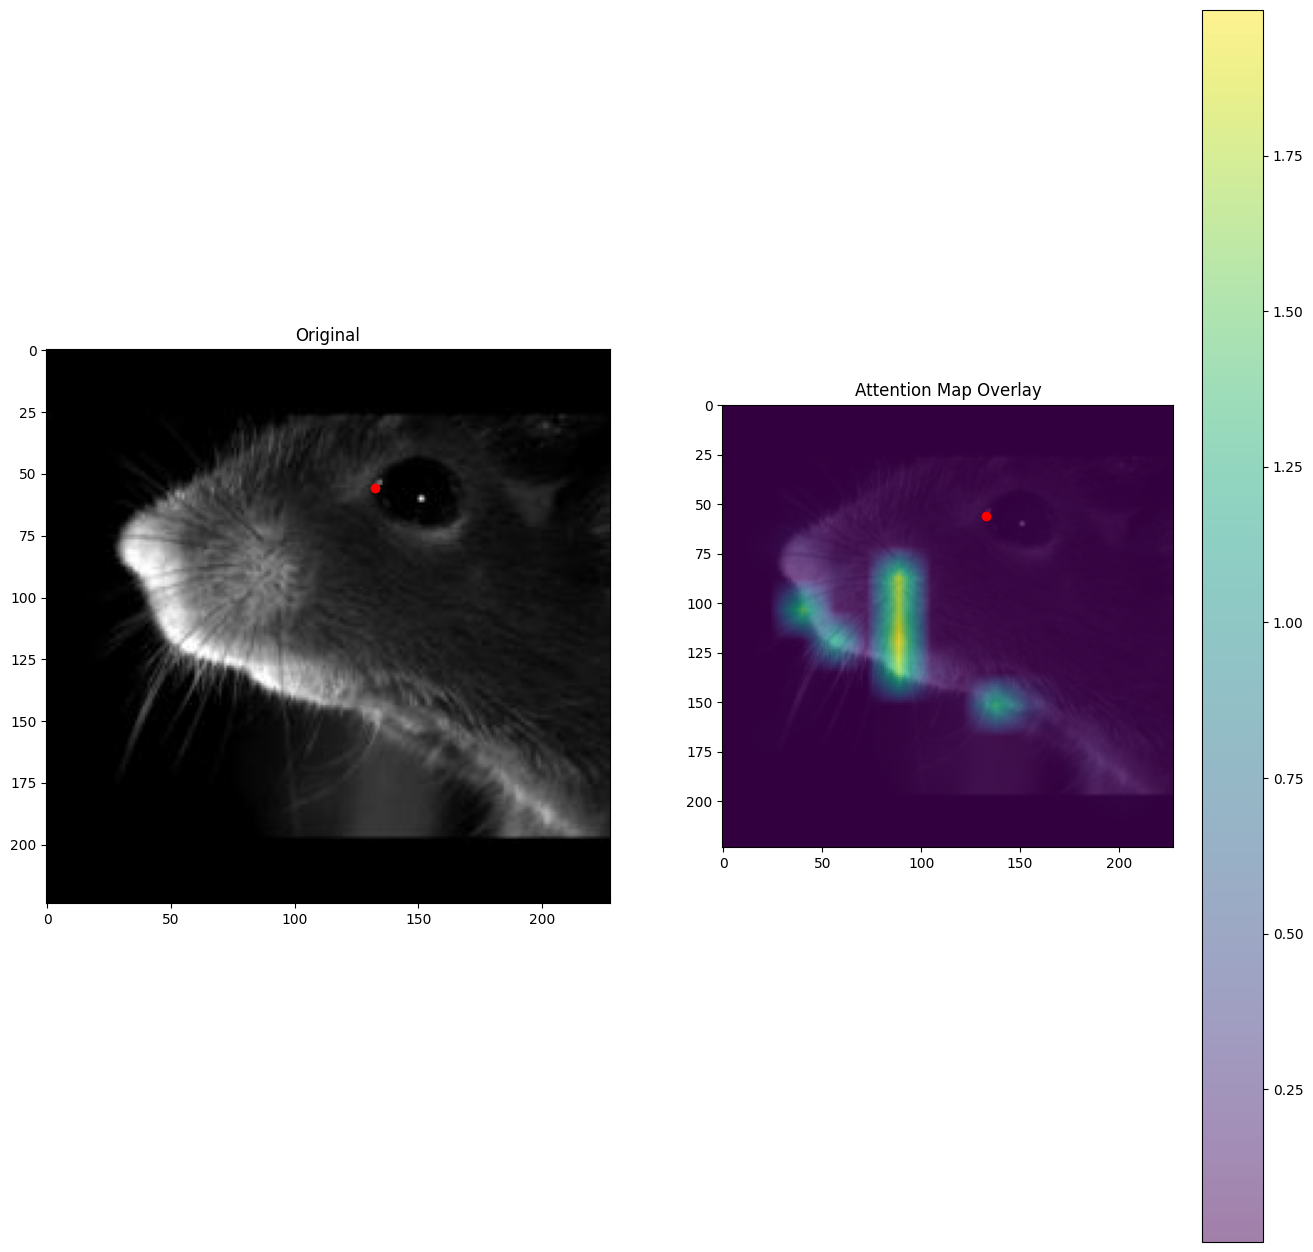

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


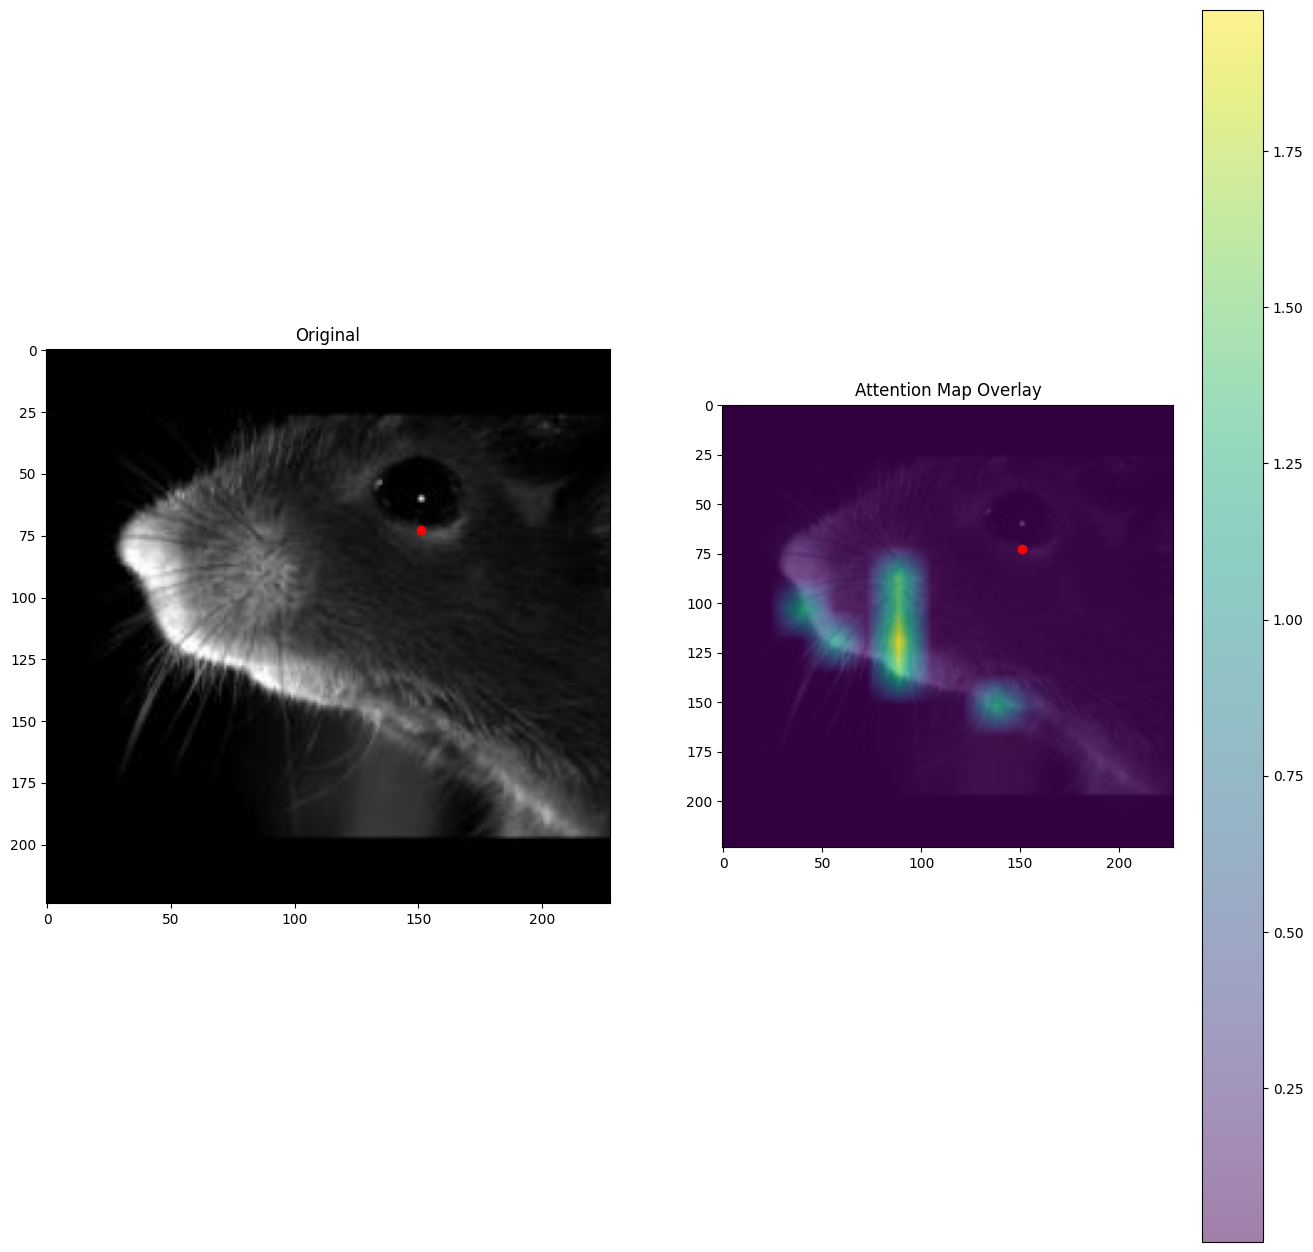

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


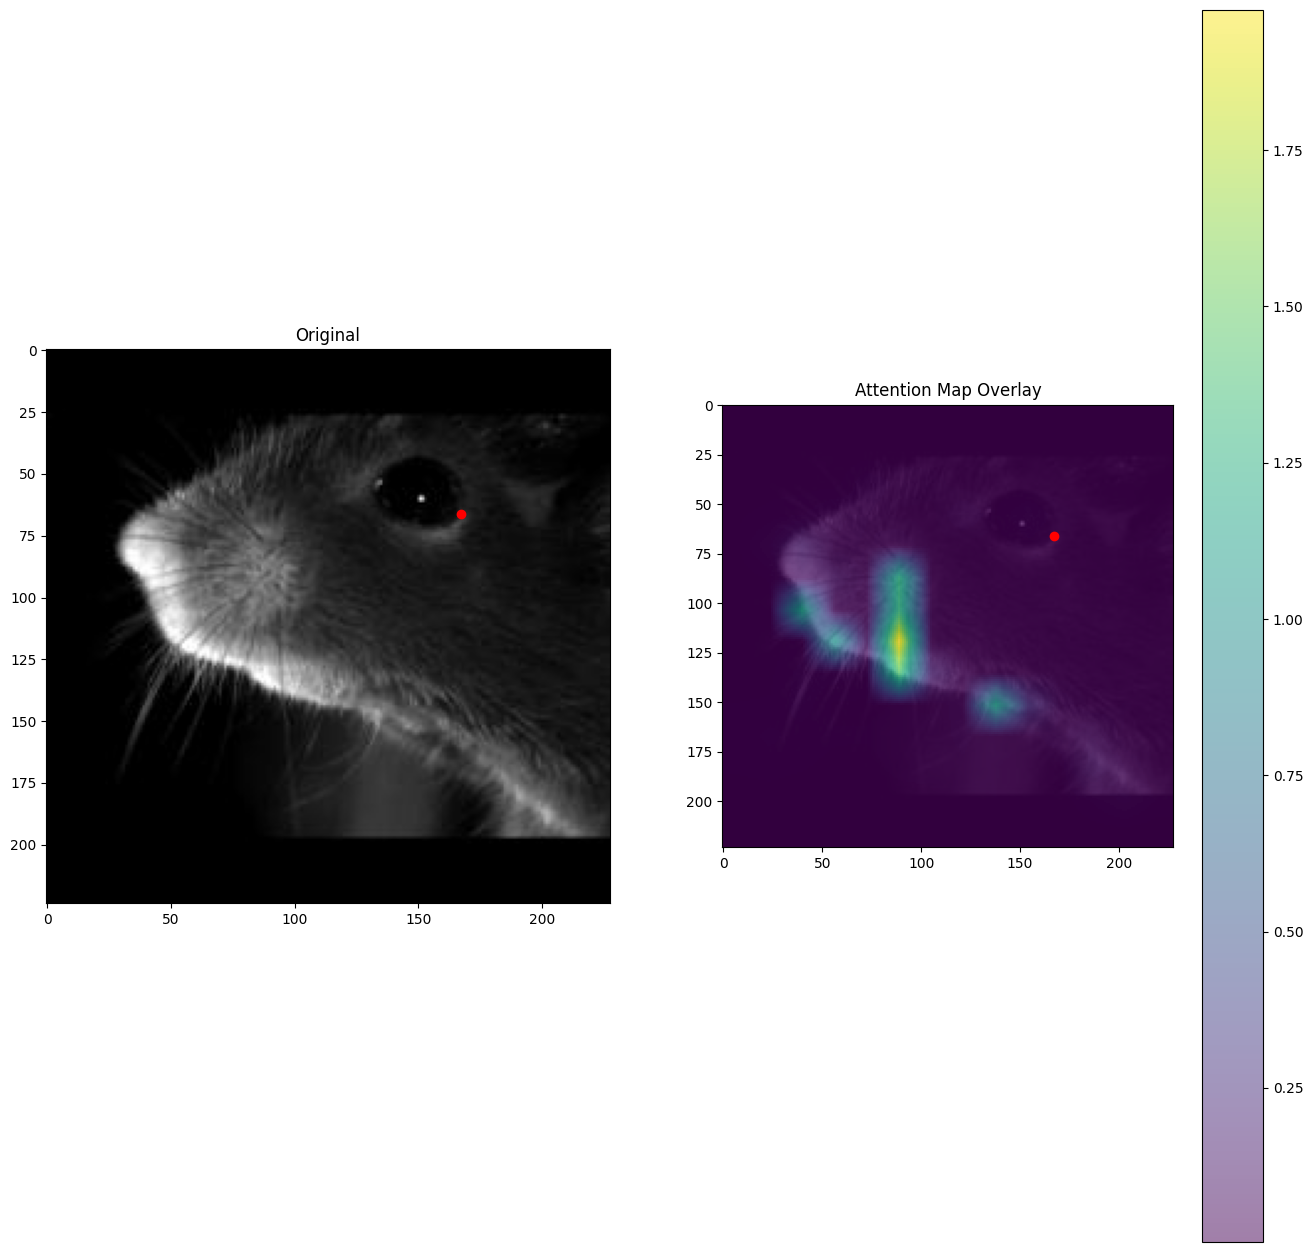

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


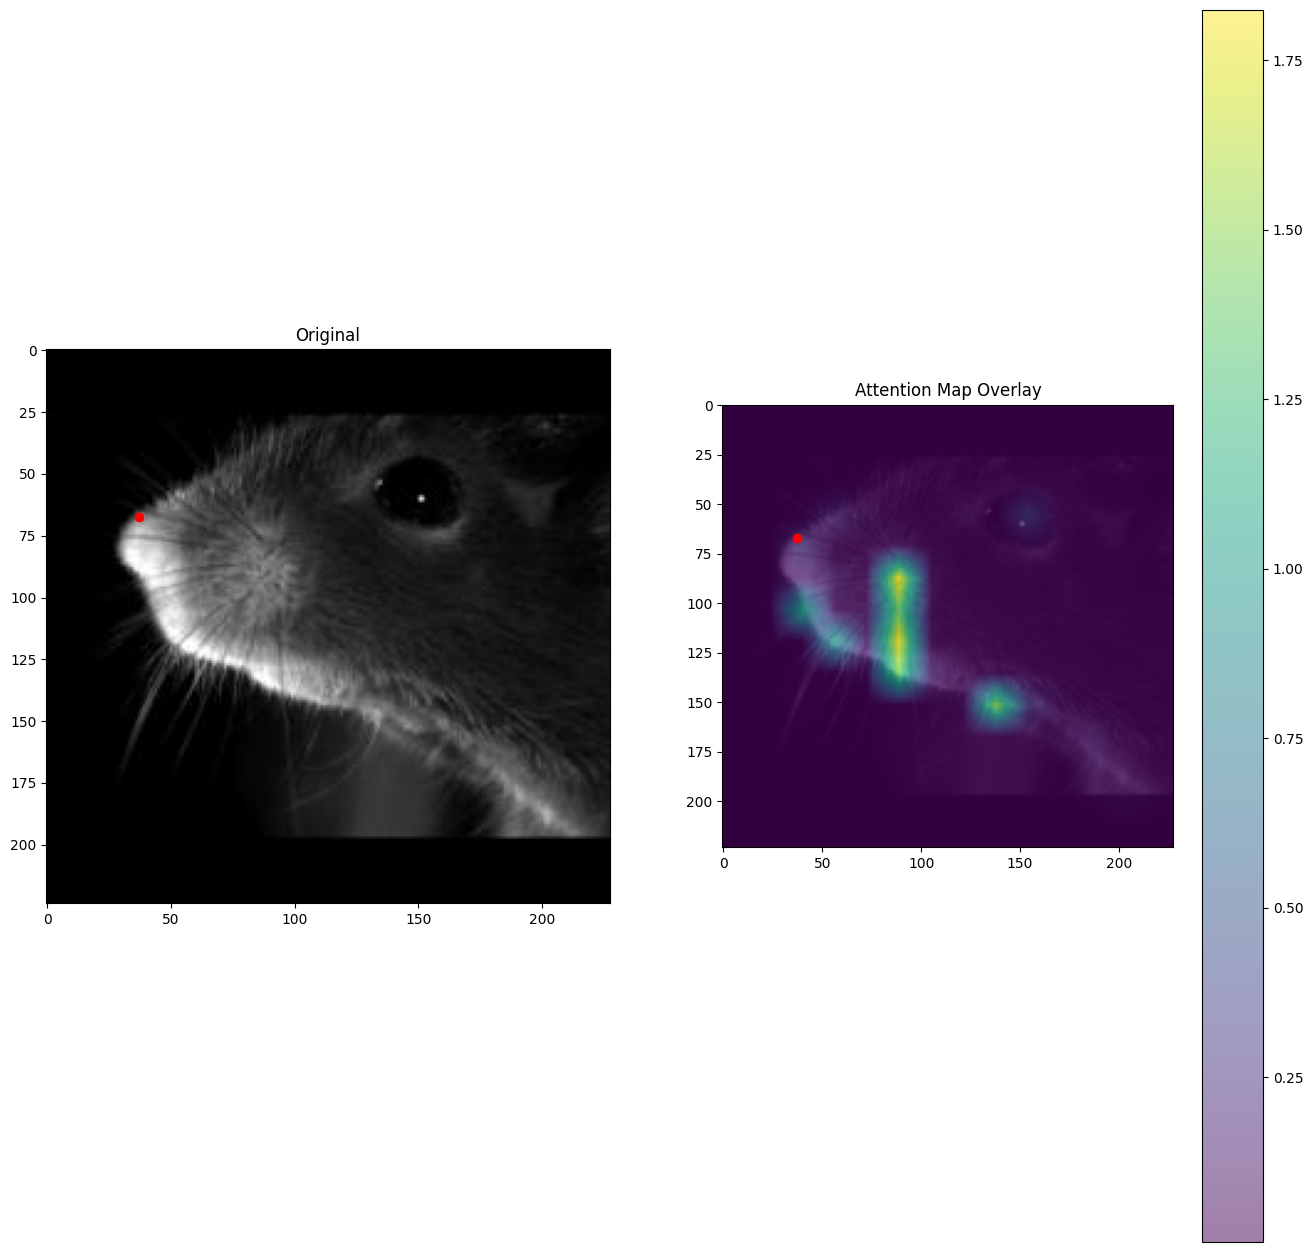

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


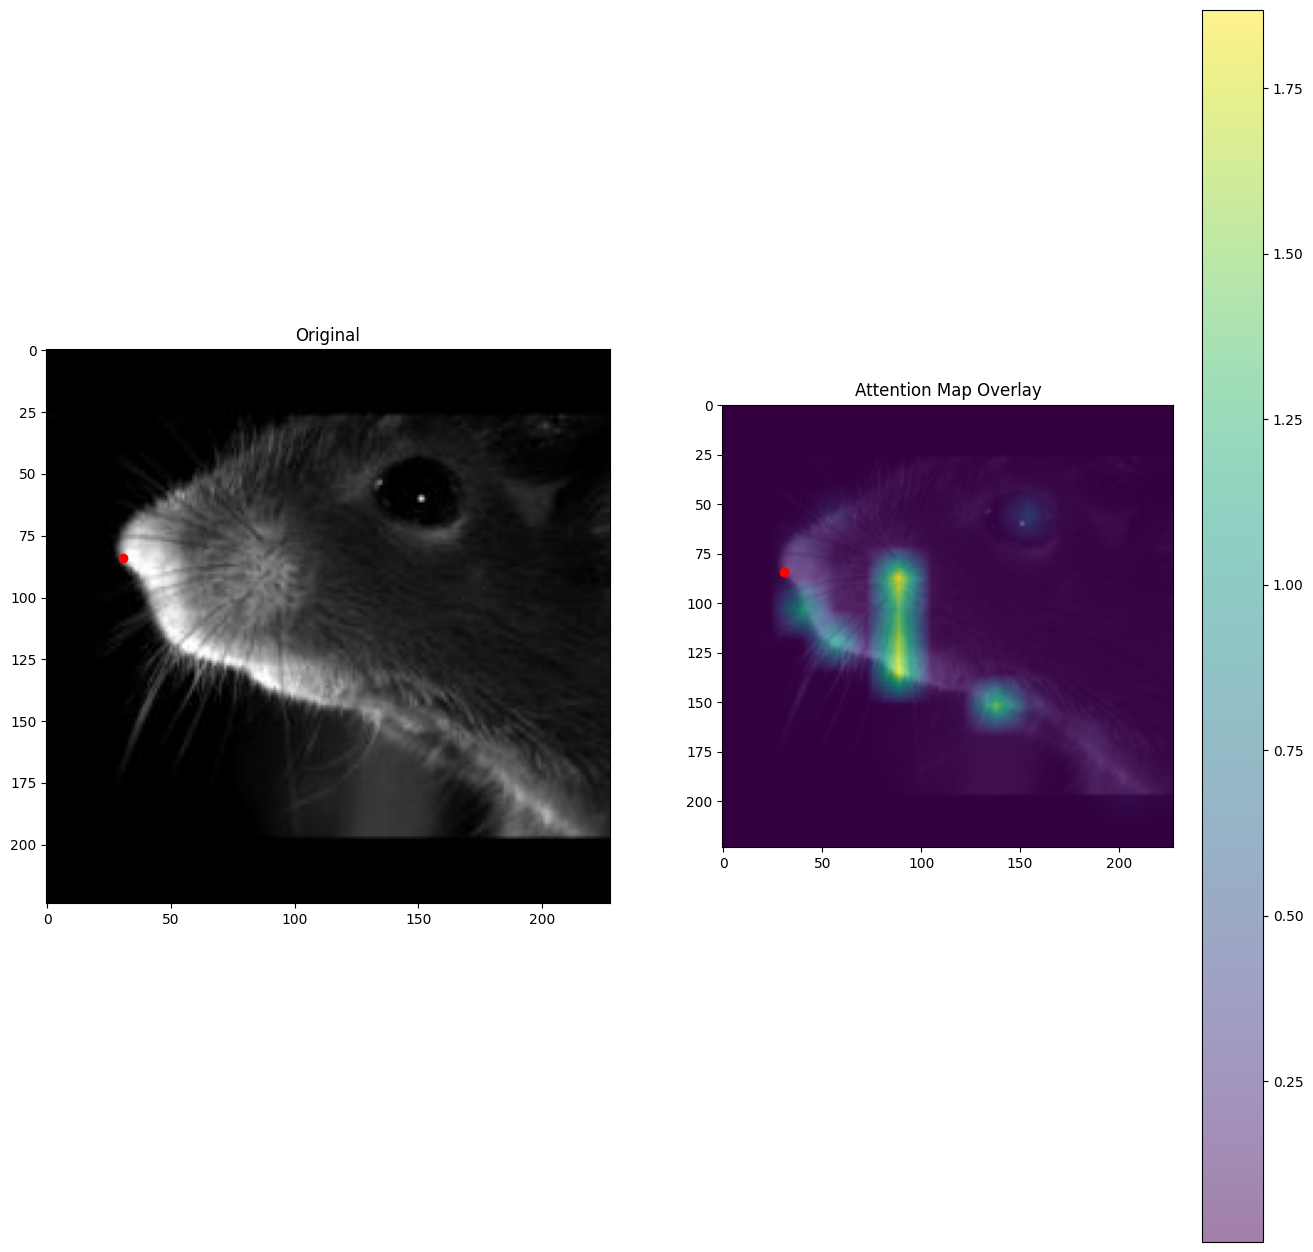

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


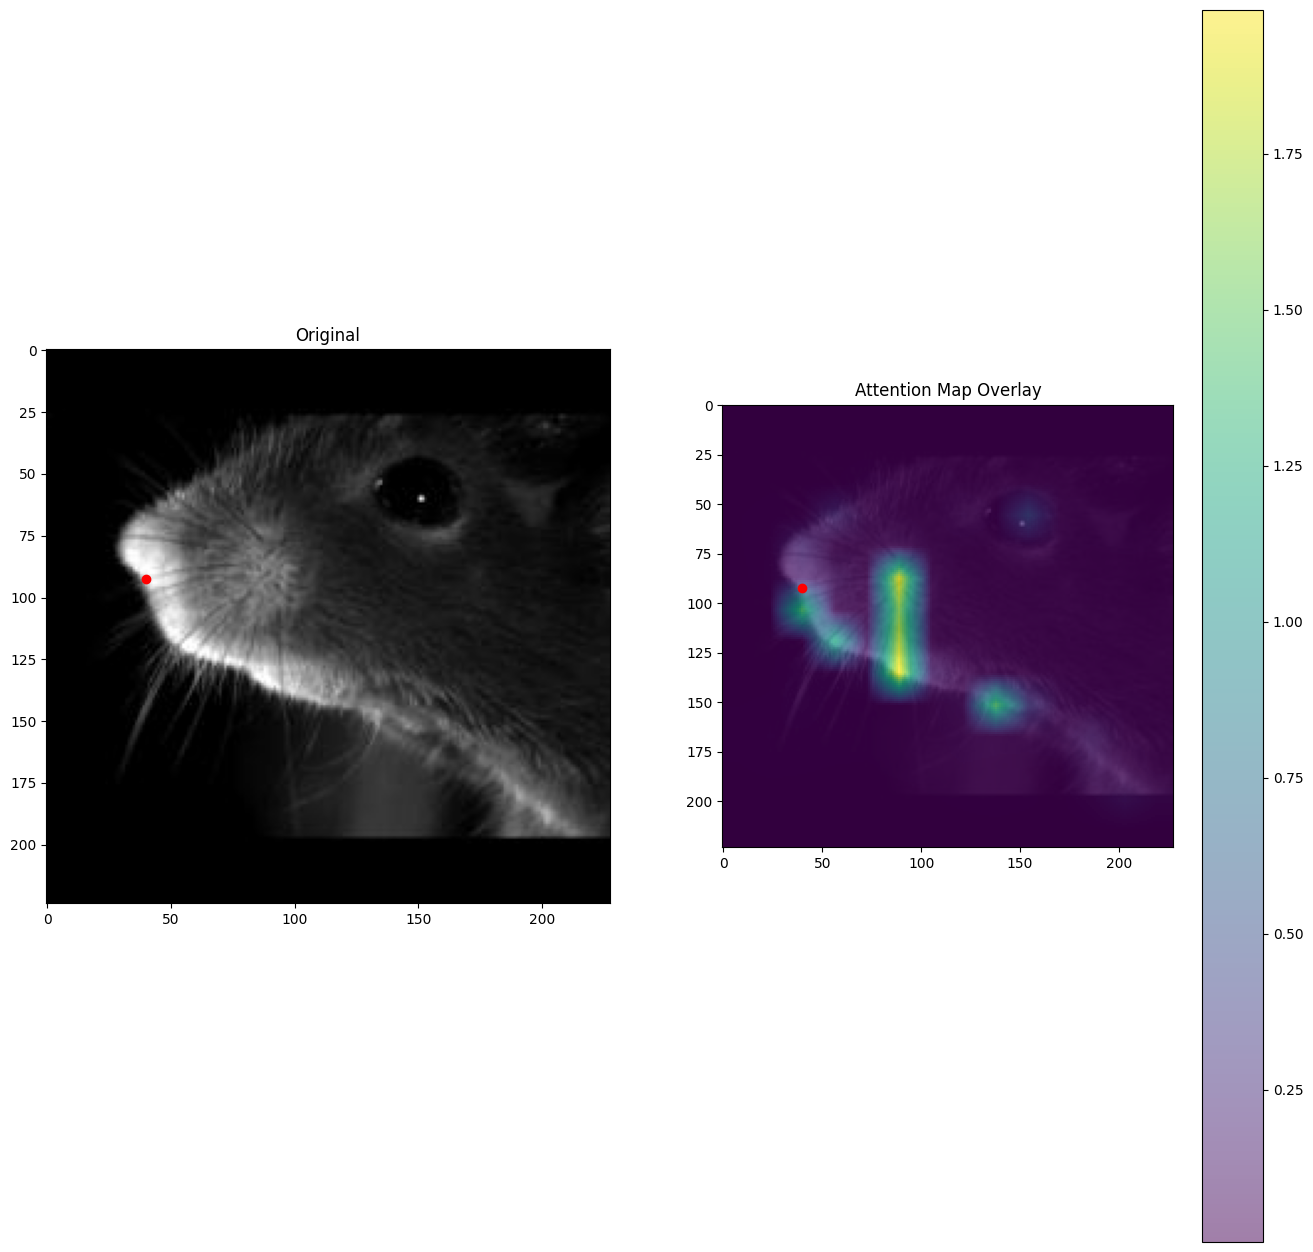

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


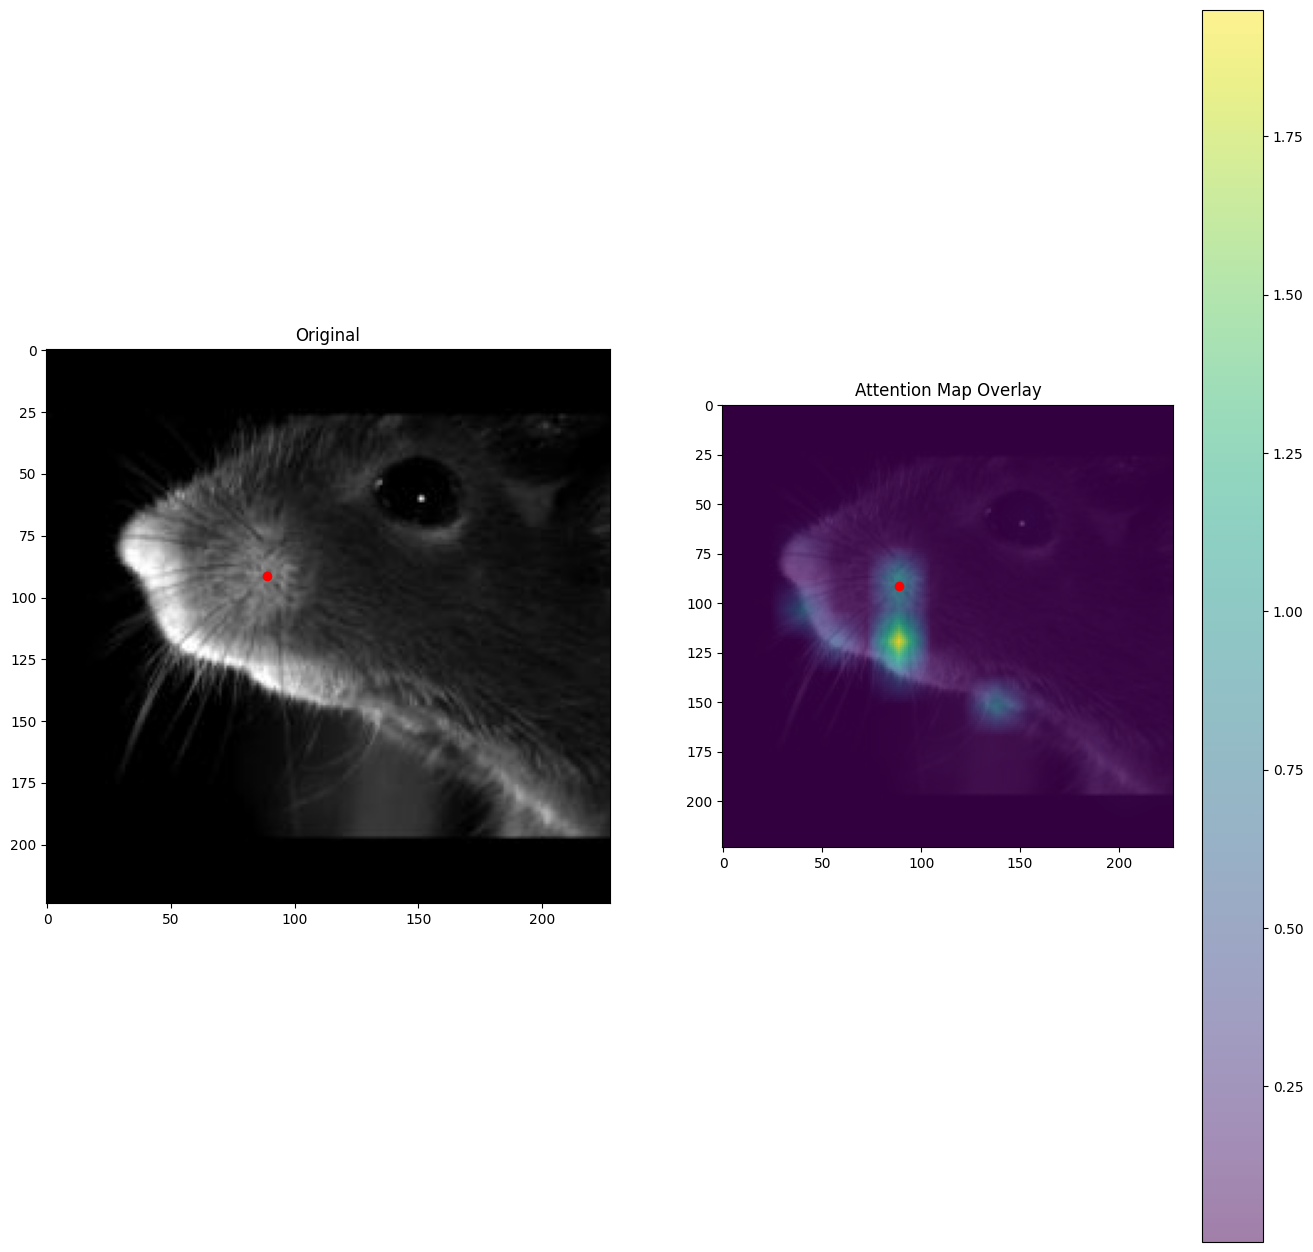

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


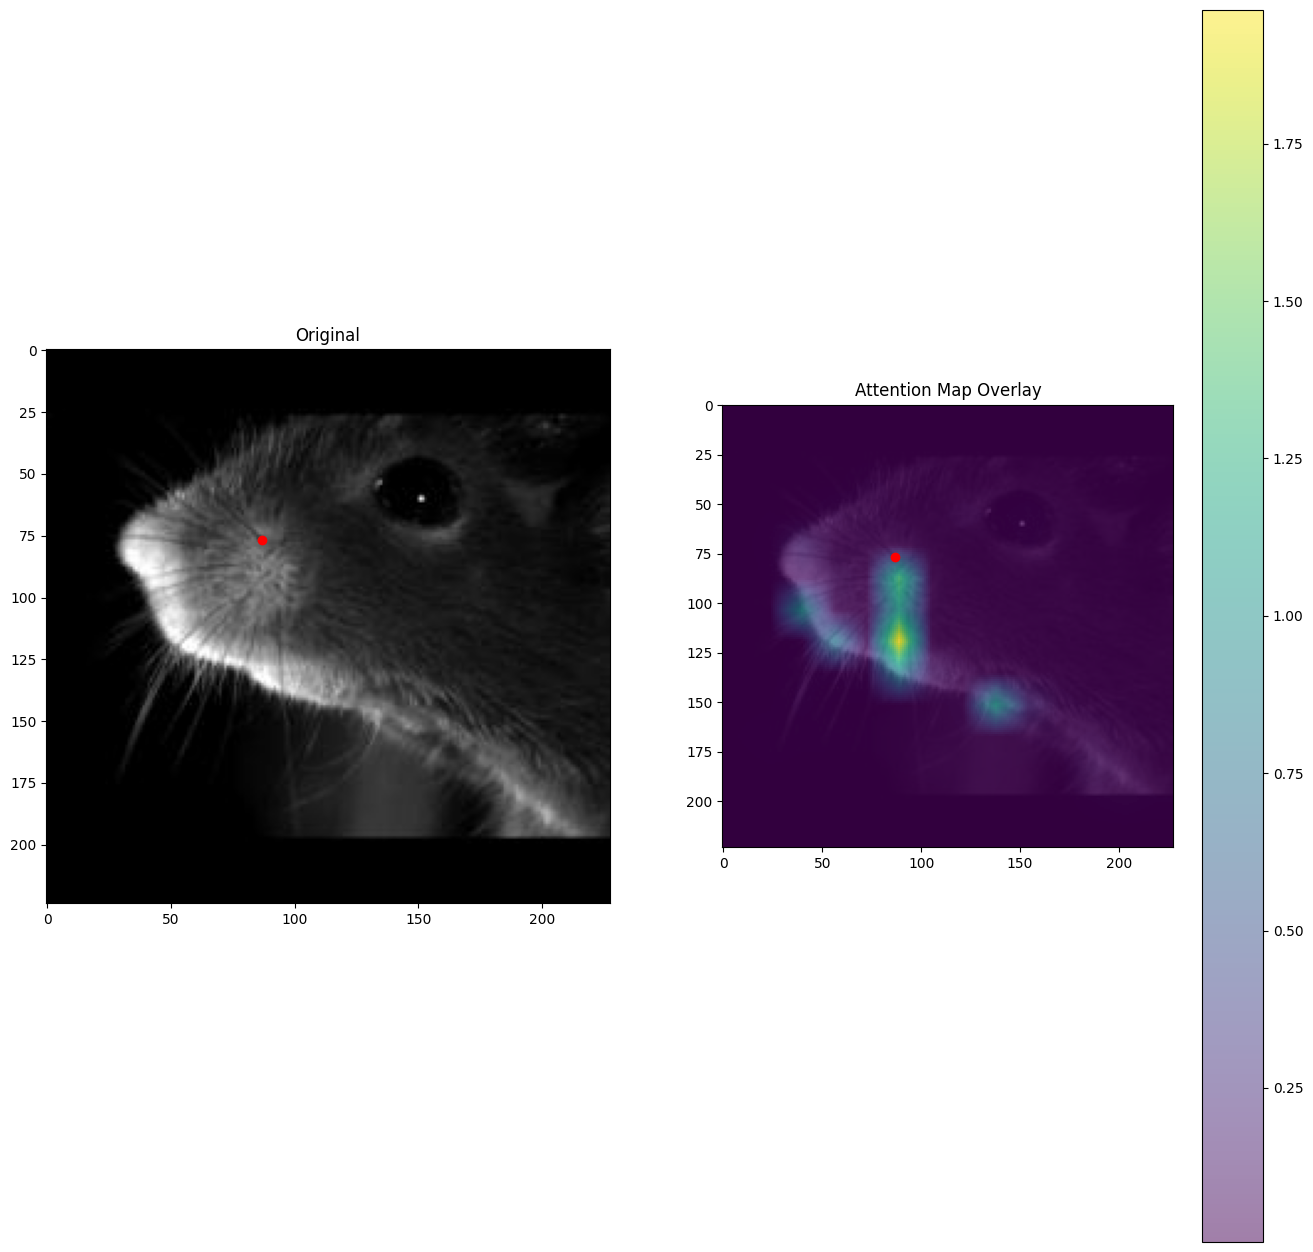

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


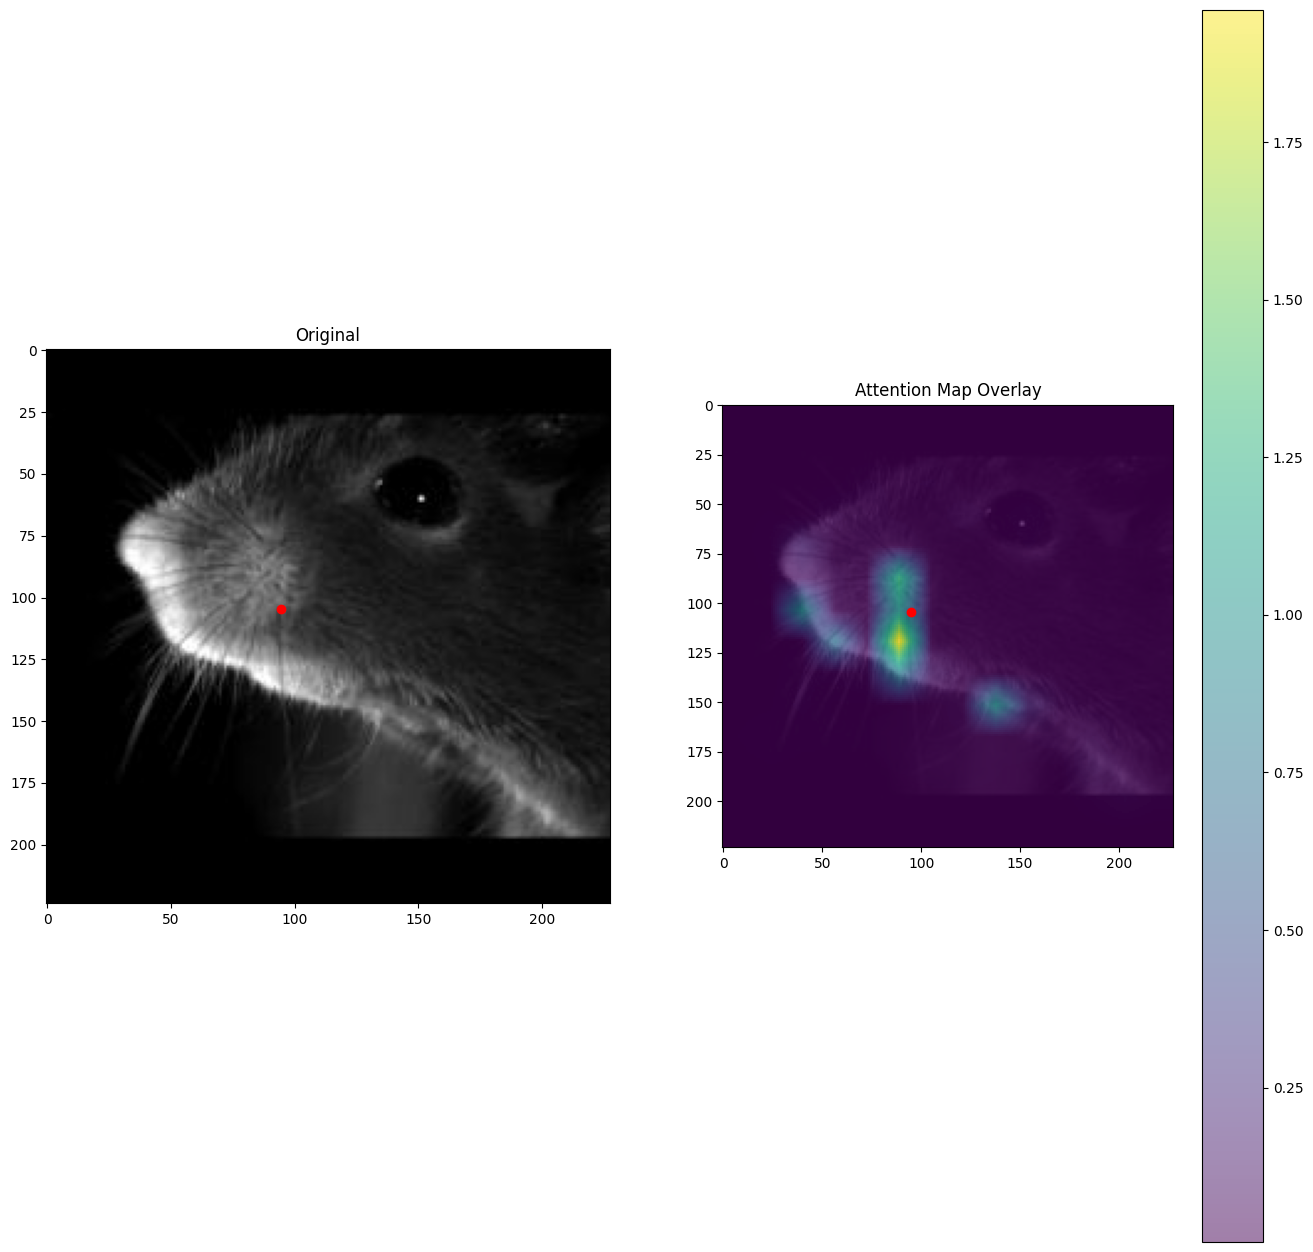

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


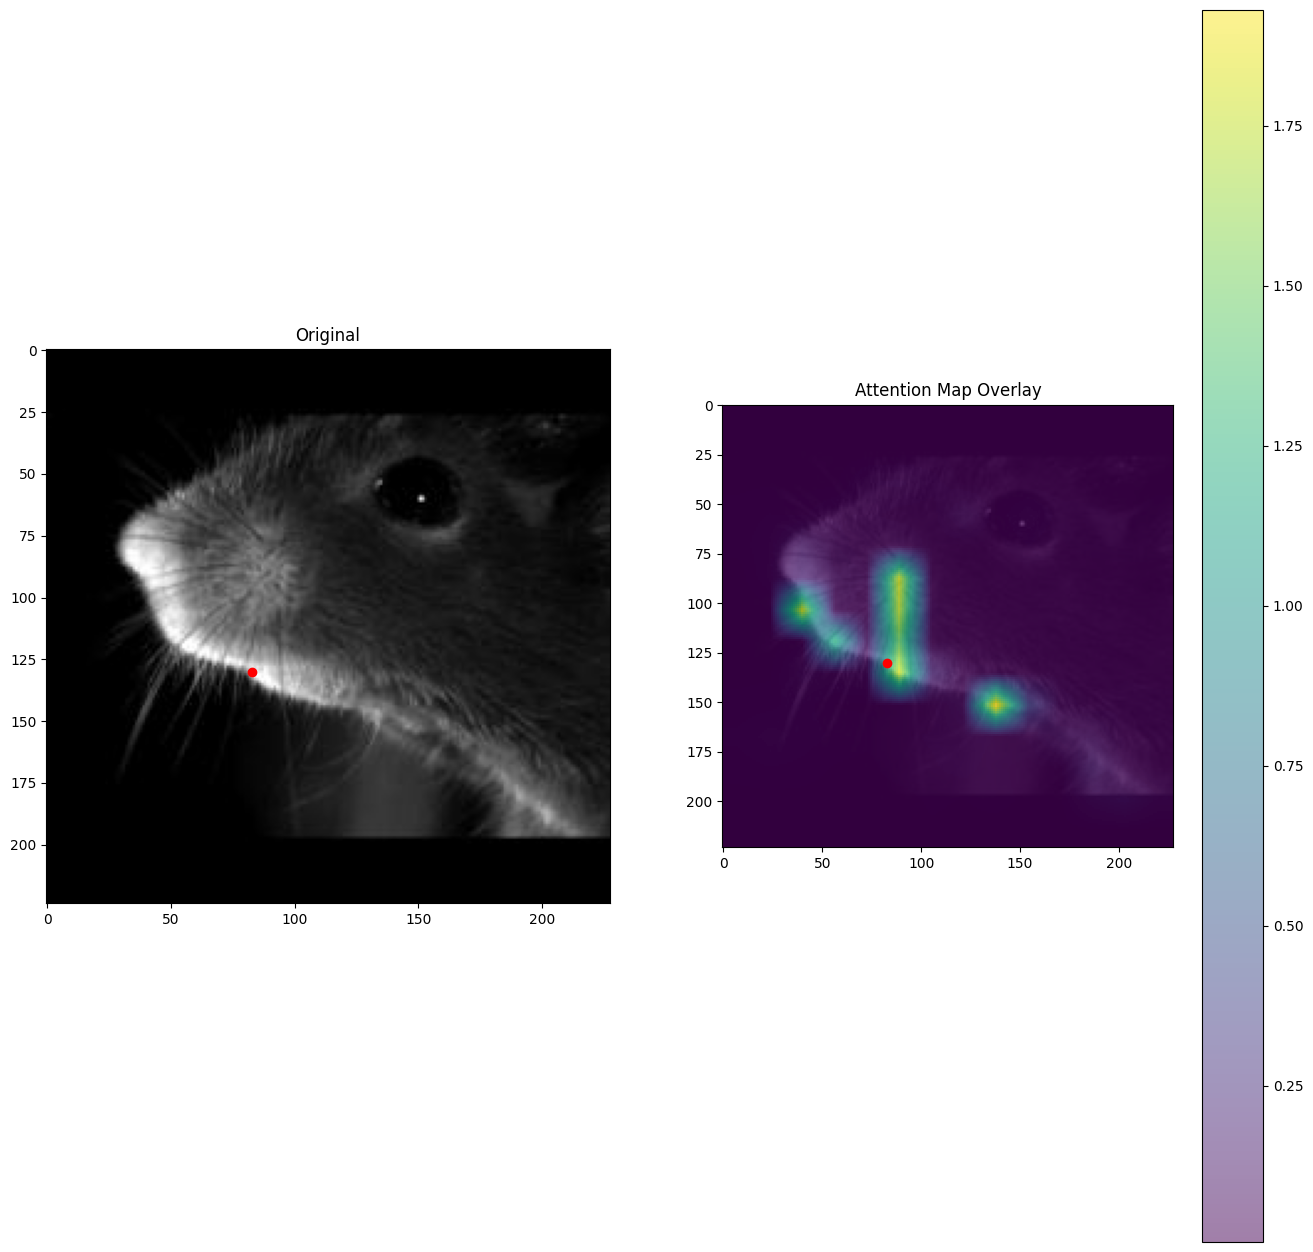

Input tensor size: torch.Size([1, 197, 768])
Input tensor size: torch.Size([1, 197, 768])


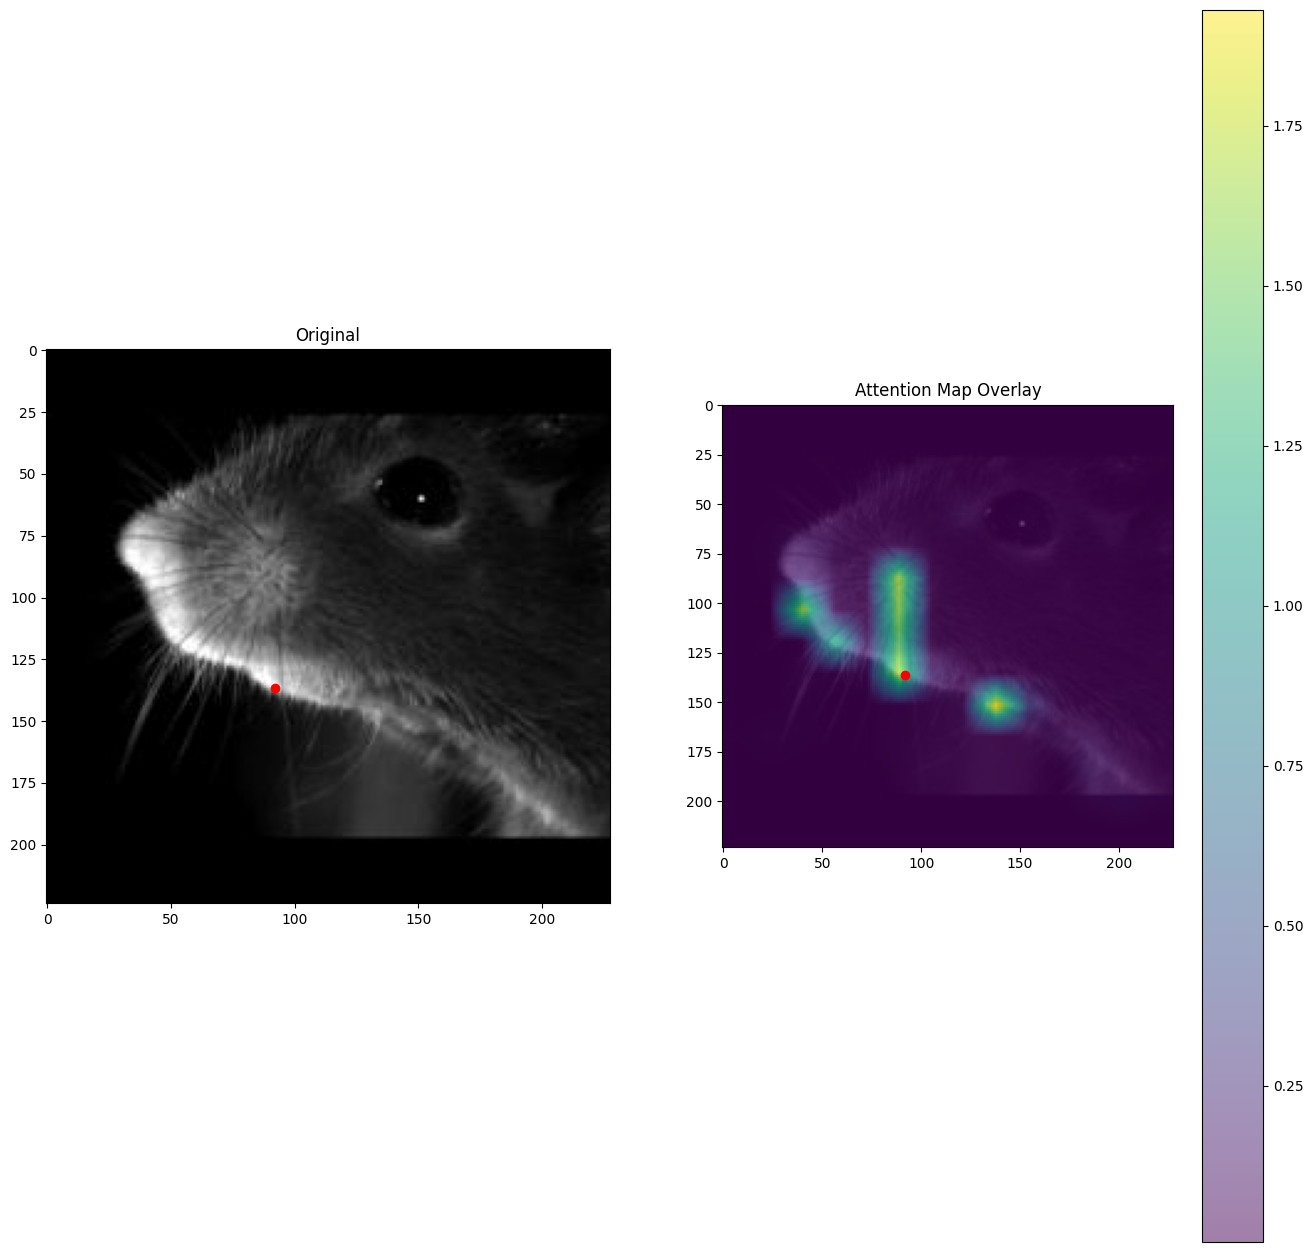

In [36]:
# NOT ADAPTED
import cv2

# Display the original image and attention map
#keypoints = [74.13194083494960, 42.812873202013800, 95.30841192338180, 56.58447399279880, 78.44566642703760, 72.3234463251248, 60.40645031466930, 66.42133170050260, 188.64174746128700,	65.6343830838861, 197.6613555174720,	82.94725264944450,	189.81821807731100,	91.21021312391570,	137.26919722823800,	90.81673881560770,	141.19076594831900,	77.43861233313060,	133.3476285081590,	105.37528822300900,	145.11233466839900,	129.77069533811400,	138.0535109722550,	136.85323288766000]
#Here I have manually inserted the key points for the image we are investigating

# Define the data path in an OS-independent way
data_path = Path("projects") / "Facemap_w_aug_ViT_resnet" / "data" / "test" / "augmented_data"

#imageName = 'img6725_rotate_rescale_augmented.jpg'
imageName = 'cam1_G7c1_2_img8261_pad_rescale_augmented.jpg'
im = Image.open(data_path / imageName)
x = transform(im)
x.size()

labels = pd.read_csv(data_path /'augmented_labels.csv')
labelsKepoints = labels.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:]

preds = pd.read_csv('predictions.csv')
predsKeypoints = preds.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:-1]
from attention_map_visualization.vit_grad_rollout import VITAttentionGradRollout

# Loop through the keypoints and visualize attention maps
for i in range(0, 23, 2):  # Loop through every other keypoint
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=0.0)
    
    # Generate attention mask for keypoint pairs (i, i+1 for x, y coordinates)
    mask = grad_rollout(x.unsqueeze(0), category_index=i) + grad_rollout(x.unsqueeze(0), category_index=i+1)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    
    ax1.set_title('Original')
    ax2.set_title('Attention Map Overlay')
    
    # Display the original image in ax1
    ax1.imshow(im)
    
    # Convert PIL image to NumPy array for OpenCV
    np_img = np.array(im)[:, :, ::-1]  # Convert RGB to BGR for OpenCV compatibility
    
    # Resize the mask to match the image dimensions
    mask_resized = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    
    # Display the original image in ax2
    ax2.imshow(im)
    
    # Overlay the mask on the original image with transparency
    ax2.imshow(mask_resized, cmap='viridis', interpolation='nearest', alpha=0.5)  # Adjust alpha to control transparency
    

    ax1.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro') #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 
    ax2.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro')

    #ax1.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10) #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 
    #ax2.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10)
    
    # Add colorbar for the attention mask in ax2
    cax = ax2.imshow(mask_resized, cmap='viridis', interpolation='nearest', alpha=0.5)  # Overlay the mask again for colorbar
    fig.colorbar(cax, ax=ax2, orientation='vertical')
    
    # Show the final plots
    plt.show()


# Loading model from wandb

In [ ]:
import wandb
from pathlib import Path

# Initialize the WandB API
api = wandb.Api()

# Replace with your project path and run ID
project_path = "anna-stuckert-university-of-st-andrews/facemap_project"

#find the run_id by going to your run of choice, and check the URL
# https://wandb.ai/anna-stuckert-university-of-st-andrews/facemap_project/runs/2hjtqnwr?nw=nwuserannastuckert
# here it would be 2hjtqnwr
run_id = "2hjtqnwr"

# Get the specific run
run = api.run(f"{project_path}/{run_id}")

# Define the file path - this is the path inside the wandb repo where the model is stored. in this case, the mode(s) is stored in the output/ folder in the files folder under the run in wandb.
file_path = "output/facemap_with_augmentation_300epochs_checkpoint_epoch_299.pth"

# Download the file
file = run.file(file_path)

# Specify the download directory (defaults to current working directory)
output_dir = Path("projects") / "Facemap" / "wandb_model"

# Download the file
downloaded_file_path = file.download(replace=True, root=output_dir)

# Print the actual download location
print(f"Downloaded {file.name} to {downloaded_file_path}")


In [ ]:
from models.modeling import VisionTransformer, CONFIGS
import torch

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_KPs=24, zero_head=False, img_size=224, vis=True)
# Define the path in an OS-independent way
checkpoint_path = Path(output_dir/ file_path)
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))  # Load the checkpoint #delete map_location=torch.device('cpu') if run on GPU
model.load_state_dict(checkpoint['state_dict'])
print(model)

In [ ]:
print(downloaded_file_path)

# Visualize loss curve



In [ ]:
# Using train.py producing lossCurve in steps
d_lossCurve = pd.read_csv('lossCurve.csv')

colors = {'training_loss': 'blue', 'validation_loss': 'orange'}  # Define colors for different metrics
metric_labels = {'training_loss': 'Training Loss', 'validation_loss': 'Test Loss'}  # Rename metrics
labels2 = {'validation_loss':'Test loss', 'training_loss':'Training loss'}
for metric, color in colors.items():
    indices = [i for i, m in enumerate(d_lossCurve['metric']) if m == metric]
    #print(f"Metric: {metric}, Indices: {indices}")  # Debug print statement
    if indices:
        #steps = [d_lossCurve['steps'][i] for i in indices]
        steps = [i*2 for i, _ in enumerate(indices)]
        loss = [d_lossCurve['training_loss'][i] for i in indices]
        if metric == 'training_loss':
            stepsPerEpoch = 49
            steps = np.arange(61)

            loss = [np.mean(loss[i*stepsPerEpoch:(i+1)*stepsPerEpoch]) for i in steps]
            
        #print(f"Steps: {steps}, Loss: {loss}")  # Debug print statement
        plt.plot(steps, loss, label=f'{labels2[metric]}', color=color)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Set the y-axis to scientific notation
plt.yscale('log')

plt.show()

In [ ]:
# Using train_epochs.py, producing lossCurve in epochs
import pandas as pd
import matplotlib.pyplot as plt

d_lossCurve = pd.read_csv('lossCurve.csv')

colors = {'training_loss': 'blue', 'validation_loss': 'orange'}  # Define colors for different metrics
metric_labels = {'training_loss': 'Training Loss', 'validation_loss': 'Test Loss'}  # Rename metrics
labels2 = {'validation_loss':'Test loss', 'training_loss':'Training loss'}
for metric, color in colors.items():
    indices = [i for i, m in enumerate(d_lossCurve['metric']) if m == metric]
    #print(f"Metric: {metric}, Indices: {indices}")  # Debug print statement
    if indices:
        steps = [d_lossCurve['epoch'][i] for i in indices]
        #steps = [i*2 for i, _ in enumerate(indices)]
        loss = [d_lossCurve['training_loss'][i] for i in indices]
        # if metric == 'training_loss':
        #     stepsPerEpoch = 49
        #     steps = np.arange(61)

        #     loss = [np.mean(loss[i*stepsPerEpoch:(i+1)*stepsPerEpoch]) for i in steps]
            
        #print(f"Steps: {steps}, Loss: {loss}")  # Debug print statement
        plt.plot(steps, loss, label=f'{labels2[metric]}', color=color)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Set the y-axis to scientific notation
plt.yscale('log')

plt.show()

# Evaluation metrics

## PCK

PCK measures the percentage of keypoints that are predicted correctly within a certain normalized distance from the ground truth keypoints.

In [ ]:
import numpy as np
import pandas as pd

#Works for the original labels.csv file in the data repo

def calculate_pck(labels, preds, alpha=0.2, reference_points=(4, 5)):
    """
    Calculate PCK (Percentage of Correct Keypoints) for each image and identify incorrect keypoints.

    Args:
        labels (pd.DataFrame): Ground truth keypoints with image names.
        preds (pd.DataFrame): Predicted keypoints with image names.
        alpha (float): Threshold for PCK, typically 0.2.
        reference_points (tuple): Indices of keypoints to use as reference for normalization.

    Returns:
        pck_results (dict): Dictionary of image_name to (PCK value, list of incorrect keypoints).
    """
    pck_results = {}
    num_keypoints = (labels.shape[1] - 1) // 2  # Assuming first column is 'image_name'

    for _, row in labels.iterrows():
        image_name = row['image_name']
        label_keypoints = row.values[1:].reshape(num_keypoints, 2)  # Ground truth keypoints
        print(label_keypoints)
        
        pred_row = preds.loc[preds['image_names'] == image_name]
        if pred_row.empty:
            print(f"No predictions found for image {image_name}")
            continue
        pred_keypoints = pred_row.values[0][1:-1].reshape(num_keypoints, 2)  # Predicted keypoints
        print(pred_keypoints)

        # Calculate reference distance (e.g., shoulder distance)
        ref_distance = np.linalg.norm(label_keypoints[reference_points[0]] - label_keypoints[reference_points[1]])
        threshold_distance = alpha * ref_distance

        correct_keypoints = 0
        incorrect_keypoints = []  # To track which keypoints are incorrect

        for j in range(num_keypoints):
            distance = np.linalg.norm(pred_keypoints[j] - label_keypoints[j])
            if distance < threshold_distance:
                correct_keypoints += 1
            else:
                incorrect_keypoints.append(j)  # Store the index of the incorrect keypoint

        pck = correct_keypoints / num_keypoints
        pck_results[image_name] = (pck, incorrect_keypoints)  # Store PCK and incorrect keypoints

    return pck_results

# Load the data
labels = pd.read_csv('augmented_data_test/augmented_labels.csv')
preds = pd.read_csv('predictions.csv')

# Calculate PCK - automatically use the distance between eye_top and eye_bottom (which I expect to be quite stable) as reference pair (1,3).
# KP should be within 10% of the distance between the ref pair
pck_results = calculate_pck(labels, preds, alpha=0.1, reference_points=(1, 3))

# Print results
for image_name, (pck_value, incorrect_keypoints) in pck_results.items():
    print(f"Image: {image_name}, PCK: {pck_value:.2f}, Incorrect Keypoints: {incorrect_keypoints}")




In [ ]:
#WORKS ON THE PRODUCED LABELS

import pandas as pd
from utils.performance_metrics import calculate_pck
# Load the data
labels = pd.read_csv('labels.csv')
preds = pd.read_csv('predictions.csv')

# Calculate PCK
pck_results = calculate_pck(labels, preds, alpha=0.1, reference_points=(1, 3))

# Print results
for image_name, (pck_value, incorrect_keypoints) in pck_results.items():
    print(f"Image: {image_name}, PCK: {pck_value:.2f}, Incorrect Keypoints: {incorrect_keypoints}")


In [ ]:
from utils.performance_metrics import calculate_pck, calculate_rmse, average_pck, average_rmse
# Load the data
 #Usage example
# Load the data
labels = pd.read_csv('labels.csv')
preds = pd.read_csv('predictions.csv')

# Calculate PCK
pck_results = calculate_pck(labels, preds, alpha=0.1, reference_points=(1, 3))

# Calculate RMSE
rmse_results = calculate_rmse(labels, preds)

# Print PCK and RMSE results
for image_name, (pck_value, incorrect_keypoints) in pck_results.items():
    rmse_value = rmse_results.get(image_name, None)
    print(f"Image: {image_name}, PCK: {pck_value:.2f}, Incorrect Keypoints: {incorrect_keypoints}, RMSE: {rmse_value:.4f}")

# Calculate and print average PCK and RMSE
avg_pck = average_pck(pck_results)
avg_rmse = average_rmse(rmse_results)
print(f"Average PCK: {avg_pck:.2f}, Average RMSE: {avg_rmse:.4f}")